# FIN 554 : Strategy Project (Sovereign Bonds Analysis)
## Macro-indicators plus moemntum indicators based Machine learning-aided modeling of fixed income instruments
### Group members: Yadvesh, Krish, Gaurav, Ganesh

In [141]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import glob
import re
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# 1) Importing the Sovereign Bonds Data

### 1.1) Treasury Bonds Data

In [83]:
import os
current_dir = os.getcwd()
sovereign_folder_path = os.path.join(current_dir, "Sovereign_Data")
print(sovereign_folder_path)

c:\Users\yadve\OneDrive\Desktop\FIN 554 - Algo Trading\Strategy Project\Sovereign_Data


In [84]:
def read_csv_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    csv_files.sort(key=lambda x: int(re.search(r'_(\d{4})', x).group(1)))

    dataframes = []
    total_rows = 0

    print("Individual CSV file statistics:")
    for file in csv_files:
        filename = os.path.splitext(os.path.basename(file))[0]
        year = re.search(r'_(\d{4})', filename).group(1)
        df = pd.read_csv(file)
        rows, cols = df.shape
        total_rows += rows
        print(f"{year}: {rows} rows, {cols} columns")
        dataframes.append(df)

    if dataframes:
        combined_df = pd.concat(dataframes, axis=0, ignore_index=True, join='outer')
        combined_df = combined_df.fillna(pd.NA)
        combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%m/%d/%Y')
        combined_df = combined_df.sort_values('Date')
        combined_df.set_index("Date", inplace=True)

        combined_rows, combined_cols = combined_df.shape
        print(f"\nCombined DataFrame: {combined_rows} rows, {combined_cols} columns")

        if combined_rows == total_rows:
            print("Row count check: Passed. Combined DataFrame has the same number of rows as the sum of individual CSVs.")
        else:
            print(f"Row count check: Failed. Combined DataFrame has {combined_rows} rows, but the sum of individual CSVs is {total_rows} rows.")

        return combined_df

    else:
        print("No CSV files found in the specified folder.")
        return None

In [85]:
sovereign_data = read_csv_files(sovereign_folder_path)

Individual CSV file statistics:
1993: 250 rows, 11 columns
1994: 249 rows, 11 columns
1995: 250 rows, 11 columns
1996: 252 rows, 11 columns
1997: 250 rows, 11 columns
1998: 250 rows, 11 columns
1999: 251 rows, 11 columns
2000: 251 rows, 11 columns
2001: 248 rows, 12 columns
2002: 250 rows, 12 columns
2003: 250 rows, 11 columns
2004: 250 rows, 11 columns
2005: 250 rows, 11 columns
2006: 250 rows, 12 columns
2007: 251 rows, 12 columns
2008: 251 rows, 12 columns
2009: 250 rows, 12 columns
2010: 252 rows, 12 columns
2011: 250 rows, 12 columns
2012: 250 rows, 12 columns
2013: 250 rows, 12 columns
2014: 250 rows, 12 columns
2015: 251 rows, 12 columns
2016: 250 rows, 12 columns
2017: 250 rows, 12 columns
2018: 249 rows, 13 columns
2019: 250 rows, 13 columns
2020: 251 rows, 13 columns
2021: 251 rows, 13 columns
2022: 249 rows, 14 columns
2023: 250 rows, 14 columns

Combined DataFrame: 7756 rows, 13 columns
Row count check: Passed. Combined DataFrame has the same number of rows as the sum of in

In [86]:
sovereign_data

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,1 Mo,2 Mo,4 Mo
Date,,,,,,,,,,,,,
1993-01-04,3.19,3.37,3.56,4.48,5.03,5.90,6.33,6.60,NaN,7.33,NaN,NaN,NaN
1993-01-05,3.18,3.36,3.58,4.48,5.00,5.90,6.32,6.61,NaN,7.33,NaN,NaN,NaN
1993-01-06,3.17,3.35,3.62,4.52,5.06,5.94,6.36,6.63,NaN,7.34,NaN,NaN,NaN
1993-01-07,3.19,3.38,3.70,4.64,5.17,6.05,6.49,6.76,NaN,7.45,NaN,NaN,NaN
1993-01-08,3.13,3.30,3.56,4.50,5.06,5.97,6.44,6.75,NaN,7.47,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,5.44,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05,5.54,5.52,5.45
2023-12-26,5.45,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04,5.53,5.52,5.44
2023-12-27,5.44,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95,5.55,5.53,5.42


In [87]:
## now we need only data between October 30, 1993 and October 30, 2023 [Also only for 1 Year, 3 Year, 10 Year, 20 Year and 30 year]
def slice_dataframe(df, start_date, end_date, cols):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df = df.sort_index()
    nearest_start = df.index[df.index >= pd.to_datetime(start_date)][0]
    nearest_end = df.index[df.index <= pd.to_datetime(end_date)][-1]

    sliced_df = df.loc[nearest_start:nearest_end]

    selected_columns = cols
    sliced_df = sliced_df[selected_columns]
    print(f"Sliced DataFrame: {sliced_df.shape[0]} rows, {sliced_df.shape[1]} columns")
    print(f"Date range: from {sliced_df.index.min()} to {sliced_df.index.max()}")
    print(f"Selected columns: {', '.join(selected_columns)}")

    return sliced_df

In [88]:
sliced_sovereign_data = slice_dataframe(sovereign_data, start_date='1993-10-30', end_date='2023-10-30', cols= ['1 Yr', '3 Yr', '10 Yr', '20 Yr', '30 Yr'])

Sliced DataFrame: 7506 rows, 5 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: 1 Yr, 3 Yr, 10 Yr, 20 Yr, 30 Yr


In [89]:
def full_plot(df, column):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label=f'{column} Treasury', color='green', linewidth=1)
    plt.title(f'Treasury Rates: {column}')
    plt.xlabel('Date')
    plt.ylabel('Rate (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

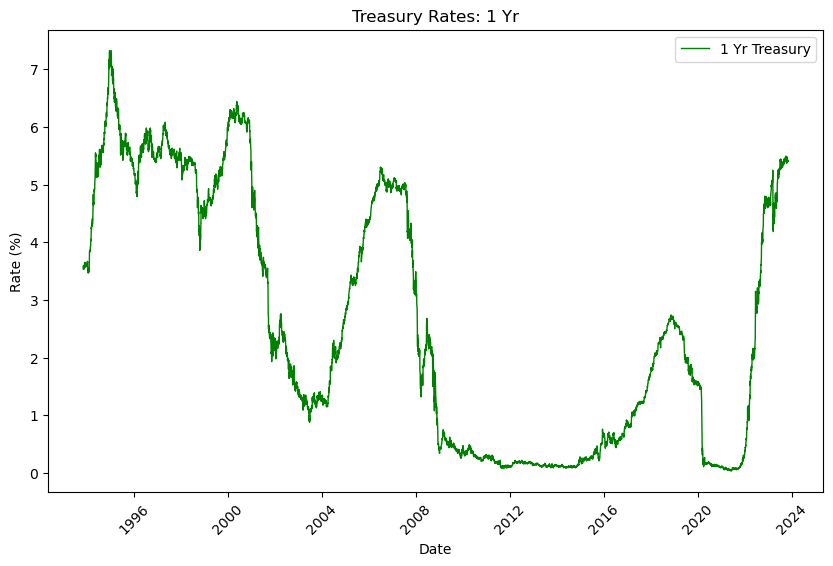

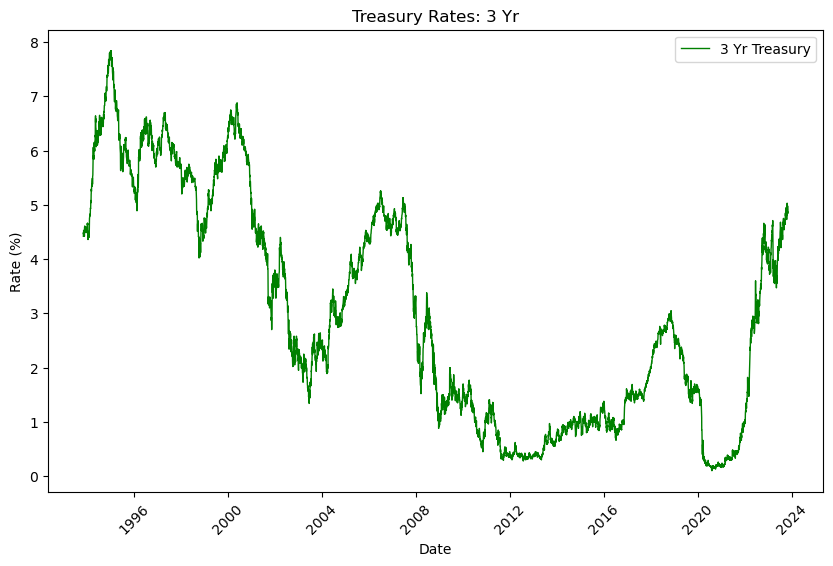

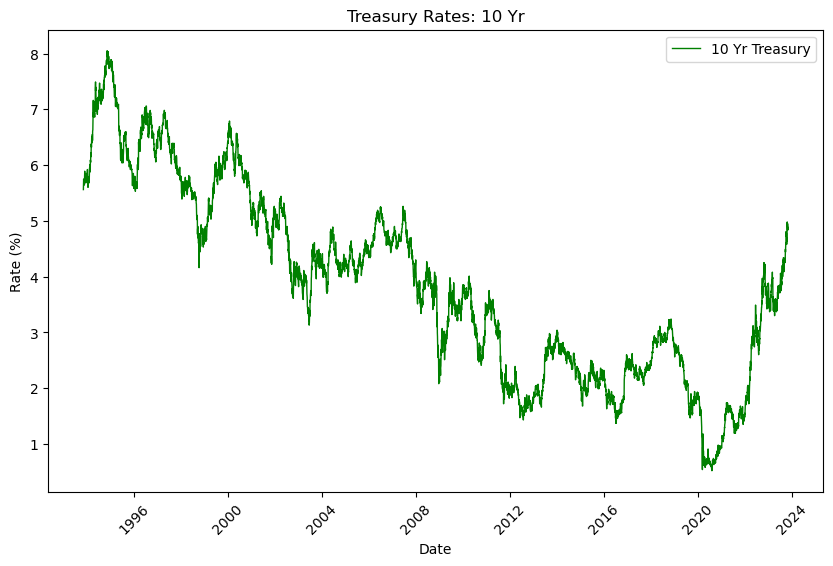

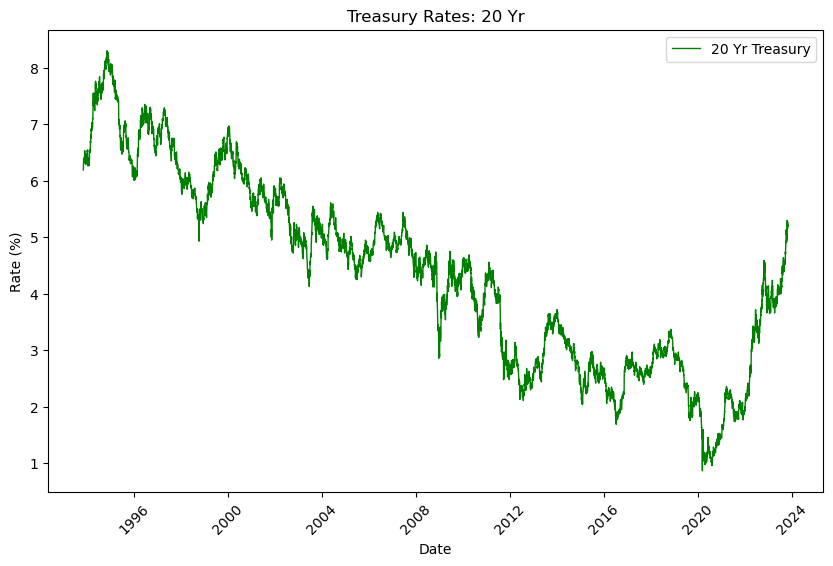

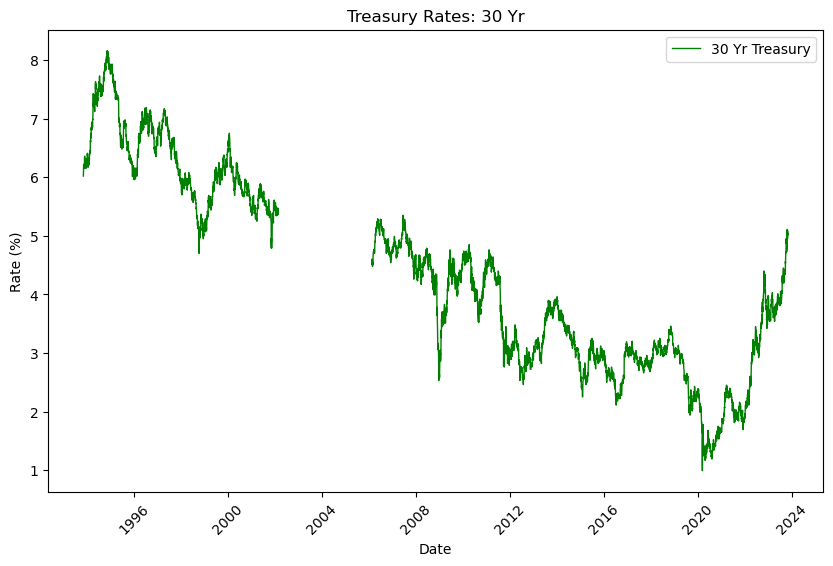

In [90]:
bond_yrs = ['1 Yr', '3 Yr', '10 Yr', '20 Yr', '30 Yr']
for term in bond_yrs:
    full_plot(sliced_sovereign_data, term)

In [91]:
# check for null values
sliced_sovereign_data.isna().sum()

1 Yr       1
3 Yr       1
10 Yr      1
20 Yr      1
30 Yr    995
dtype: int64

In [92]:
## As we Saw above there are a lot of values missing for 30 Yr Treasury Bond so we will fetch the data for them through yfinance
import yfinance as yf
data = yf.download("^TYX", period="max")
data['30 Yr YF'] = data['Adj Close']
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,30 Yr YF
Date,,,,,,,
1977-02-15,7.700,7.700,7.700,7.700,7.700,0,7.700
1977-02-16,7.670,7.670,7.670,7.670,7.670,0,7.670
1977-02-17,7.670,7.670,7.670,7.670,7.670,0,7.670
1977-02-18,7.760,7.760,7.760,7.760,7.760,0,7.760
1977-02-22,7.770,7.770,7.770,7.770,7.770,0,7.770
...,...,...,...,...,...,...,...
2024-12-09,4.368,4.392,4.351,4.390,4.390,0,4.390
2024-12-10,4.426,4.432,4.404,4.408,4.408,0,4.408
2024-12-11,4.440,4.483,4.406,4.479,4.479,0,4.479


In [93]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
yf_data_sliced = slice_dataframe(data, start_date='1993-10-30', end_date='2023-10-30', cols= ['30 Yr YF'])

Sliced DataFrame: 7533 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: 30 Yr YF


In [94]:
yf_data_sliced

,30 Yr YF
Date,
1993-11-01,6.020
1993-11-02,6.058
1993-11-03,6.094
1993-11-04,6.180
1993-11-05,6.217
...,...
2023-10-24,4.963
2023-10-25,5.092
2023-10-26,4.988


In [95]:
## now merging this with original sliced datafarme sliced_sovereign_data
merged_sovereign_data = sliced_sovereign_data.merge(yf_data_sliced, left_index=True, right_index=True)
merged_sovereign_data

,1 Yr,3 Yr,10 Yr,20 Yr,30 Yr,30 Yr YF
Date,,,,,,
1993-11-01,3.53,4.42,5.56,6.19,6.02,6.020
1993-11-02,3.59,4.49,5.63,6.28,6.07,6.058
1993-11-03,3.56,4.46,5.67,6.32,6.11,6.094
1993-11-04,3.55,4.47,5.67,6.34,6.19,6.180
1993-11-05,3.58,4.53,5.75,6.40,6.22,6.217
...,...,...,...,...,...,...
2023-10-24,5.41,4.91,4.83,5.15,4.96,4.963
2023-10-25,5.43,4.98,4.95,5.27,5.09,5.092
2023-10-26,5.39,4.89,4.86,5.19,5.01,4.988


In [96]:
merged_sovereign_data.isna().sum()

1 Yr          0
3 Yr          0
10 Yr         0
20 Yr         0
30 Yr       994
30 Yr YF      0
dtype: int64

In [97]:
## As we saw above there are no nulls in data from yahoo finance so we'll use that for the 30 Yr treasurey bond.
sovereign_data_final = merged_sovereign_data.drop(['30 Yr'], axis=1)
sovereign_data_final.rename(columns={"30 Yr YF": "30 Yr"}, inplace=True)
sovereign_data_final.head()

,1 Yr,3 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,
1993-11-01,3.53,4.42,5.56,6.19,6.020
1993-11-02,3.59,4.49,5.63,6.28,6.058
1993-11-03,3.56,4.46,5.67,6.32,6.094
1993-11-04,3.55,4.47,5.67,6.34,6.180
1993-11-05,3.58,4.53,5.75,6.40,6.217


In [98]:
# check for nulls
sovereign_data_final.isna().sum()

1 Yr     0
3 Yr     0
10 Yr    0
20 Yr    0
30 Yr    0
dtype: int64

In [99]:
sovereign_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7493 entries, 1993-11-01 to 2023-10-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1 Yr    7493 non-null   float64
 1   3 Yr    7493 non-null   float64
 2   10 Yr   7493 non-null   float64
 3   20 Yr   7493 non-null   float64
 4   30 Yr   7493 non-null   float64
dtypes: float64(5)
memory usage: 351.2 KB


### 1.2) Adding Macro Variables

In [100]:
current_dir = os.getcwd()
macro_folder_path = os.path.join(current_dir, "Macro_Data")
print(macro_folder_path)

c:\Users\yadve\OneDrive\Desktop\FIN 554 - Algo Trading\Strategy Project\Macro_Data


### 1.2.1) Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average

In [101]:
cpi_file = os.path.join(macro_folder_path, "CPILFESL.csv")

In [102]:
df_cpi = pd.read_csv(cpi_file, index_col="DATE")
# primary null check
df_cpi.isna().sum()

CPILFESL    0
dtype: int64

In [103]:
df_cpi['inflation'] = df_cpi['CPILFESL'].pct_change()*100
df_cpi

,CPILFESL,inflation
DATE,,
1993-01-01,150.100,NaN
1993-02-01,150.600,0.333111
1993-03-01,150.800,0.132802
1993-04-01,151.400,0.397878
1993-05-01,151.800,0.264201
...,...,...
2023-08-01,309.656,0.230138
2023-09-01,310.644,0.319064
2023-10-01,311.390,0.240146


In [104]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
inf_data_sliced = slice_dataframe(df_cpi, start_date='1993-10-30', end_date='2023-10-30', cols= ['inflation'])
inf_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: inflation


,inflation
DATE,
1993-11-01,0.325945
1993-12-01,0.259909
1994-01-01,0.129618
1994-02-01,0.194175
1994-03-01,0.322997
...,...
2023-06-01,0.194704
2023-07-01,0.227092
2023-08-01,0.230138


In [105]:
# forward filling the inflation to preserve the daily time granualarity as 
# Suppose January CPI is released on February 10th and if we backfill January’s inflation into January’s daily data we are inserting information that 
# was not available at that time So ffill makes more sense.
new_index_inf = pd.date_range(start=inf_data_sliced.index.min(), end='2023-10-30', freq='D')
inf_data_final = inf_data_sliced.reindex(new_index_inf, method='ffill')
inf_data_final

,inflation
1993-11-01,0.325945
1993-11-02,0.325945
1993-11-03,0.325945
1993-11-04,0.325945
1993-11-05,0.325945
...,...
2023-10-26,0.240146
2023-10-27,0.240146
2023-10-28,0.240146
2023-10-29,0.240146


In [106]:
# check for nulls
inf_data_final.isna().sum()

inflation    0
dtype: int64

In [107]:
inf_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inflation  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.2) Producer Price Index by Commodity: All Commodities

In [108]:
ppi_file = os.path.join(macro_folder_path, "PPIACO.csv")

In [109]:
df_ppi = pd.read_csv(ppi_file, index_col="DATE")
#primary null check
df_ppi.isna().sum()

PPIACO    0
dtype: int64

In [110]:
df_ppi['ppi_mom'] = df_ppi['PPIACO'].pct_change()*100
df_ppi

,PPIACO,ppi_mom
DATE,,
1993-01-01,118.000,NaN
1993-02-01,118.400,0.338983
1993-03-01,118.700,0.253378
1993-04-01,119.300,0.505476
1993-05-01,119.700,0.335289
...,...,...
2023-08-01,257.680,1.514764
2023-09-01,258.934,0.486650
2023-10-01,255.192,-1.445156


In [111]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
ppi_data_sliced = slice_dataframe(df_ppi, start_date='1993-10-30', end_date='2023-10-30', cols= ['ppi_mom'])
ppi_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: ppi_mom


,ppi_mom
DATE,
1993-11-01,-0.083963
1993-12-01,-0.336134
1994-01-01,0.421585
1994-02-01,0.167926
1994-03-01,0.335289
...,...
2023-06-01,0.074900
2023-07-01,-0.009848
2023-08-01,1.514764


In [112]:
# forward filling the ppi_mom to preserve the daily time granualarity just like inflation
new_index_ppi = pd.date_range(start=ppi_data_sliced.index.min(), end='2023-10-30', freq='D')
ppi_data_final = ppi_data_sliced.reindex(new_index_ppi, method='ffill')
ppi_data_final

,ppi_mom
1993-11-01,-0.083963
1993-11-02,-0.083963
1993-11-03,-0.083963
1993-11-04,-0.083963
1993-11-05,-0.083963
...,...
2023-10-26,-1.445156
2023-10-27,-1.445156
2023-10-28,-1.445156
2023-10-29,-1.445156


In [113]:
# check for nulls
ppi_data_final.isna().sum()

ppi_mom    0
dtype: int64

In [114]:
ppi_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ppi_mom  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.3) Federal Funds Effective Rate

In [115]:
fed_funds_file = os.path.join(macro_folder_path, "FEDFUNDS.csv")

In [116]:
df_fed = pd.read_csv(fed_funds_file, index_col="DATE")
# primary null check
print(df_fed.isna().sum(), '\n')
df_fed.info()

FEDFUNDS    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 1993-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  372 non-null    float64
dtypes: float64(1)
memory usage: 5.8+ KB


In [117]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
funds_data_sliced = slice_dataframe(df_fed, start_date='1993-10-30', end_date='2023-10-30', cols= ['FEDFUNDS'])
funds_data_sliced.rename(columns={"FEDFUNDS": "fed_funds_rate"}, inplace=True)
funds_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: FEDFUNDS


,fed_funds_rate
DATE,
1993-11-01,3.02
1993-12-01,2.96
1994-01-01,3.05
1994-02-01,3.25
1994-03-01,3.34
...,...
2023-06-01,5.08
2023-07-01,5.12
2023-08-01,5.33


In [118]:
# forward filling the fed funds rate to preserve the daily time granualarity as Central banks often set a target rate that remains stable until the next decision or announcement.
new_index_fed = pd.date_range(start=funds_data_sliced.index.min(), end='2023-10-30', freq='D')
funds_data_final = funds_data_sliced.reindex(new_index_fed, method='ffill')
funds_data_final

,fed_funds_rate
1993-11-01,3.02
1993-11-02,3.02
1993-11-03,3.02
1993-11-04,3.02
1993-11-05,3.02
...,...
2023-10-26,5.33
2023-10-27,5.33
2023-10-28,5.33
2023-10-29,5.33


In [119]:
# check for nulls
funds_data_final.isna().sum()

fed_funds_rate    0
dtype: int64

In [120]:
funds_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fed_funds_rate  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.4) Unemployment Rate

In [121]:
unemp_file = os.path.join(macro_folder_path, "UNRATE.csv")

In [122]:
df_unemp = pd.read_csv(unemp_file, index_col="DATE")
# primary null check
print(df_unemp.isna().sum(), '\n')
df_unemp.info()

UNRATE    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 1993-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  372 non-null    float64
dtypes: float64(1)
memory usage: 5.8+ KB


In [123]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
unemp_data_sliced = slice_dataframe(df_unemp, start_date='1993-10-30', end_date='2023-10-30', cols= ['UNRATE'])
unemp_data_sliced.rename(columns={"UNRATE": "unemployment_rate"}, inplace=True)
unemp_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: UNRATE


,unemployment_rate
DATE,
1993-11-01,6.6
1993-12-01,6.5
1994-01-01,6.6
1994-02-01,6.6
1994-03-01,6.5
...,...
2023-06-01,3.6
2023-07-01,3.5
2023-08-01,3.8


In [124]:
# forward filling the unemployment rate to preserve the daily time granualarity as a target rate is set that remains stable until the next decision or announcement.
new_index_unemp = pd.date_range(start=unemp_data_sliced.index.min(), end='2023-10-30', freq='D')
unemp_data_final = unemp_data_sliced.reindex(new_index_unemp, method='ffill')
unemp_data_final

,unemployment_rate
1993-11-01,6.6
1993-11-02,6.6
1993-11-03,6.6
1993-11-04,6.6
1993-11-05,6.6
...,...
2023-10-26,3.8
2023-10-27,3.8
2023-10-28,3.8
2023-10-29,3.8


In [125]:
# check for nulls
unemp_data_final.isna().sum()

unemployment_rate    0
dtype: int64

In [126]:
unemp_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unemployment_rate  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.5) 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity

In [127]:
t10y2_file = os.path.join(macro_folder_path, "T10Y2Y.csv")

In [128]:
df_10y2 = pd.read_csv(t10y2_file, index_col="DATE")
# primary null check
print(df_10y2.isna().sum(), '\n')
df_10y2.info()

T10Y2Y    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 8065 entries, 1993-01-04 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T10Y2Y  8065 non-null   object
dtypes: object(1)
memory usage: 126.0+ KB


In [129]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023 and processing to get standard datatype format
t10y2_data_sliced = slice_dataframe(df_10y2, start_date='1993-10-30', end_date='2023-10-30', cols= ['T10Y2Y'])
t10y2_data_sliced.rename(columns={"T10Y2Y": "10_minus_2"}, inplace=True)
t10y2_data_sliced.reset_index(inplace=True)
t10y2_data_sliced['10_minus_2'] = t10y2_data_sliced['10_minus_2'].replace('.', np.nan)
t10y2_data_sliced['10_minus_2'] = t10y2_data_sliced['10_minus_2'].astype('float')
t10y2_data_sliced.set_index('DATE', inplace=True)
t10y2_data_sliced

Sliced DataFrame: 7826 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: T10Y2Y


,10_minus_2
DATE,
1993-11-01,1.45
1993-11-02,1.47
1993-11-03,1.54
1993-11-04,1.54
1993-11-05,1.55
...,...
2023-10-24,-0.19
2023-10-25,-0.13
2023-10-26,-0.16


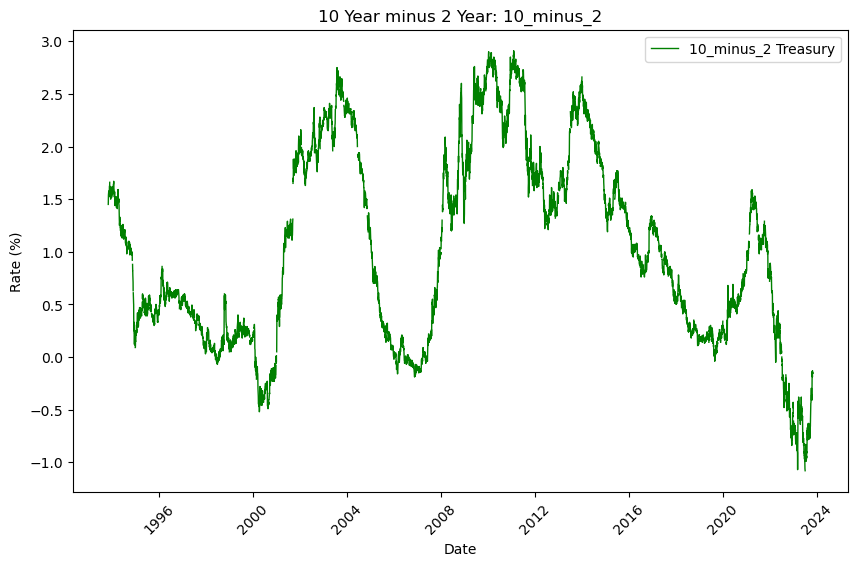

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(t10y2_data_sliced.index, t10y2_data_sliced['10_minus_2'], label=f'{'10_minus_2'} Treasury', color='green', linewidth=1)
plt.title(f'10 Year minus 2 Year: {'10_minus_2'}')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### We will impute the missing values later on using other macro data

In [131]:
t10y2_data_sliced.isna().sum()

10_minus_2    321
dtype: int64

### 1.2.6) Real GDP

In [132]:
gdp_file = os.path.join(macro_folder_path, "GDPC1.csv")

In [133]:
df_gdp = pd.read_csv(gdp_file, index_col="DATE")
# primary null check
print(df_gdp.isna().sum(), '\n')
df_gdp.info()

GDPC1_PCH    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 1993-01-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GDPC1_PCH  124 non-null    float64
dtypes: float64(1)
memory usage: 1.9+ KB


In [134]:
# forward filling the unemployment rate to preserve the daily time granualarity as a target rate is set that remains stable until the next decision or announcement.
df_gdp.index = pd.to_datetime(df_gdp.index)
new_index_gdp = pd.date_range(start=df_gdp.index.min(), end='2023-10-30', freq='D')
gdp_data = df_gdp.reindex(new_index_gdp, method='ffill')
gdp_data

,GDPC1_PCH
1993-01-01,0.16694
1993-01-02,0.16694
1993-01-03,0.16694
1993-01-04,0.16694
1993-01-05,0.16694
...,...
2023-10-26,0.78867
2023-10-27,0.78867
2023-10-28,0.78867
2023-10-29,0.78867


In [135]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
gdp_data_sliced = slice_dataframe(gdp_data, start_date='1993-11-01', end_date='2023-10-30', cols= ['GDPC1_PCH'])
gdp_data_sliced.rename(columns={"GDPC1_PCH": "gdp"}, inplace=True)
gdp_data_sliced

Sliced DataFrame: 10956 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: GDPC1_PCH


,gdp
1993-11-01,1.36015
1993-11-02,1.36015
1993-11-03,1.36015
1993-11-04,1.36015
1993-11-05,1.36015
...,...
2023-10-26,0.78867
2023-10-27,0.78867
2023-10-28,0.78867
2023-10-29,0.78867


In [136]:
gdp_data_final = gdp_data_sliced.copy()
gdp_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


# Need to add more macro indicators like 
* Chicago Fed National Financial Conditions Index
* Credit Risk Indicators (CDS Spreads, Ratings Outlook)
* Foreign Exchange Rates (e.g., USD Index)
* Consumer Confidence Index
* Business Confidence Index
* PMI
* Housing mortgage rates

# 2) Preprocessing-Data and Feature Engineering

In [137]:
macro_frames = [ppi_data_final, funds_data_final, unemp_data_final, t10y2_data_sliced, gdp_data_final]

In [138]:
df_macro = inf_data_final.join(macro_frames, how='left')
df_macro

,inflation,ppi_mom,fed_funds_rate,unemployment_rate,10_minus_2,gdp
1993-11-01,0.325945,-0.083963,3.02,6.6,1.45,1.36015
1993-11-02,0.325945,-0.083963,3.02,6.6,1.47,1.36015
1993-11-03,0.325945,-0.083963,3.02,6.6,1.54,1.36015
1993-11-04,0.325945,-0.083963,3.02,6.6,1.54,1.36015
1993-11-05,0.325945,-0.083963,3.02,6.6,1.55,1.36015
...,...,...,...,...,...,...
2023-10-26,0.240146,-1.445156,5.33,3.8,-0.16,0.78867
2023-10-27,0.240146,-1.445156,5.33,3.8,-0.15,0.78867
2023-10-28,0.240146,-1.445156,5.33,3.8,NaN,0.78867
2023-10-29,0.240146,-1.445156,5.33,3.8,NaN,0.78867


In [139]:
print(df_macro.isna().sum(), '\n')

df_macro.info()

inflation               0
ppi_mom                 0
fed_funds_rate          0
unemployment_rate       0
10_minus_2           3451
gdp                     0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inflation          10956 non-null  float64
 1   ppi_mom            10956 non-null  float64
 2   fed_funds_rate     10956 non-null  float64
 3   unemployment_rate  10956 non-null  float64
 4   10_minus_2         7505 non-null   float64
 5   gdp                10956 non-null  float64
dtypes: float64(6)
memory usage: 599.2 KB


In [158]:
# running a expanding window KNN imputer to impute the values of 10_minus_2
n_neighbors = 5
min_periods = 5
cols = ['inflation', 'ppi_mom', 'fed_funds_rate', 'unemployment_rate', 'gdp', '10_minus_2']
target_col = '10_minus_2'

df_result = df_macro.copy()

# scaler to standardise values
scaler = StandardScaler()

# missing val indices
missing_indices = df_macro[df_macro[target_col].isna()].index

# sorted dataframe to impute the values later on
df_sorted = df_macro.sort_index()

# getting non null data before the first null index
first_missing_idx = missing_indices[0]
initial_data = df_sorted.loc[:first_missing_idx].copy()
h_data = initial_data[~initial_data[target_col].isna()]

if len(h_data) < min_periods:
    print(f"Not enough initial data points (need {min_periods}, have {len(h_data)})")
else:
    # iterating at each missing index
    for idx in missing_indices:
        curr_data = df_result.loc[:idx, cols].copy()
        
        scaler.fit(curr_data)
        
        curr_data_scaled = pd.DataFrame(scaler.transform(curr_data), columns=cols, index=curr_data.index)
        
        # Fit KNN imputer using all previous data
        current_n_neighbors = min(n_neighbors, len(curr_data) - 1)
        imputer = KNNImputer(n_neighbors=current_n_neighbors)
        curr_data_imputed_scaled = imputer.fit_transform(curr_data_scaled)
        
        # Transform back to original scale
        curr_data_imputed = scaler.inverse_transform(curr_data_imputed_scaled)
        
        # Update only the current missing value
        df_result.loc[idx, target_col] = curr_data_imputed[-1][cols.index(target_col)]

# Print results
print(f"Number of missing values before imputation: {df_macro[target_col].isna().sum()}")
print(f"Number of missing values after imputation: {df_result[target_col].isna().sum()}")

Number of missing values before imputation: 3451
Number of missing values after imputation: 0


In [165]:
df_macro_imputed = df_result.copy()
df_macro_imputed.head(11)

,inflation,ppi_mom,fed_funds_rate,unemployment_rate,10_minus_2,gdp
1993-11-01,0.325945,-0.083963,3.02,6.6,1.45,1.36015
1993-11-02,0.325945,-0.083963,3.02,6.6,1.47,1.36015
1993-11-03,0.325945,-0.083963,3.02,6.6,1.54,1.36015
1993-11-04,0.325945,-0.083963,3.02,6.6,1.54,1.36015
1993-11-05,0.325945,-0.083963,3.02,6.6,1.55,1.36015
1993-11-06,0.325945,-0.083963,3.02,6.6,1.51,1.36015
1993-11-07,0.325945,-0.083963,3.02,6.6,1.51,1.36015
1993-11-08,0.325945,-0.083963,3.02,6.6,1.57,1.36015
1993-11-09,0.325945,-0.083963,3.02,6.6,1.52,1.36015
1993-11-10,0.325945,-0.083963,3.02,6.6,1.55,1.36015


In [161]:
print(df_macro_imputed.isna().sum())

inflation            0
ppi_mom              0
fed_funds_rate       0
unemployment_rate    0
10_minus_2           0
gdp                  0
dtype: int64


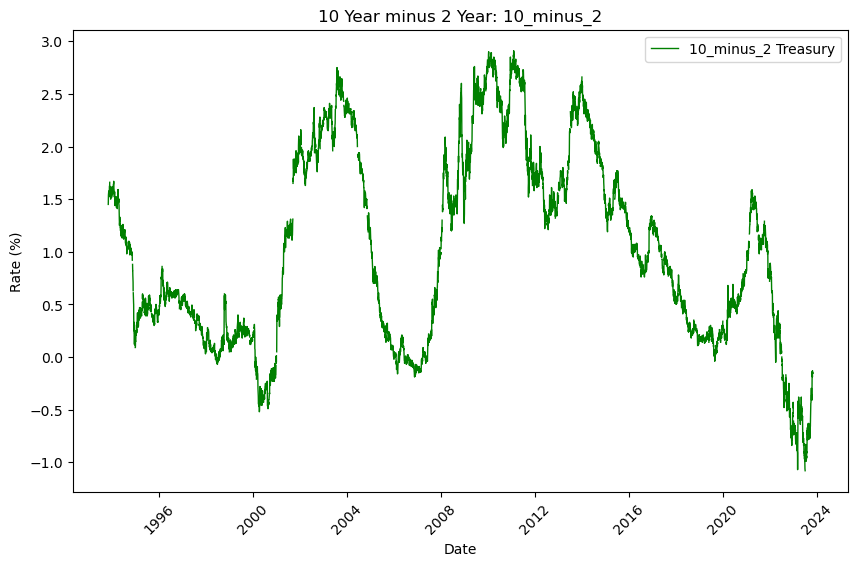

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(t10y2_data_sliced.index, t10y2_data_sliced['10_minus_2'], label=f'{'10_minus_2'} Treasury', color='green', linewidth=1)
plt.title(f'10 Year minus 2 Year: {'10_minus_2'}')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

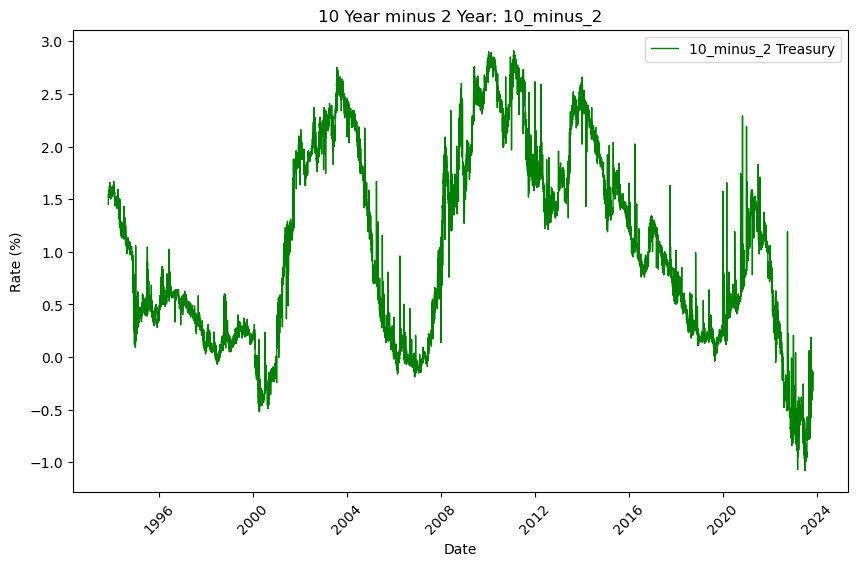

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(df_macro_imputed.index, df_macro_imputed['10_minus_2'], label=f'{'10_minus_2'} Treasury', color='green', linewidth=1)
plt.title(f'10 Year minus 2 Year: {'10_minus_2'}')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [166]:
df_macro_imputed.head()

,inflation,ppi_mom,fed_funds_rate,unemployment_rate,10_minus_2,gdp
1993-11-01,0.325945,-0.083963,3.02,6.6,1.45,1.36015
1993-11-02,0.325945,-0.083963,3.02,6.6,1.47,1.36015
1993-11-03,0.325945,-0.083963,3.02,6.6,1.54,1.36015
1993-11-04,0.325945,-0.083963,3.02,6.6,1.54,1.36015
1993-11-05,0.325945,-0.083963,3.02,6.6,1.55,1.36015


 ## Analysis for 10 - year bond

## Feature engineering

In [67]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.volatility import BollingerBands

In [68]:
sovereign_data_10 = sovereign_data_final[['10 Yr']]
sovereign_data_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7493 entries, 1993-11-01 to 2023-10-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   10 Yr   7493 non-null   float64
dtypes: float64(1)
memory usage: 117.1 KB


In [69]:
df = sovereign_data_10.copy()
df = df.sort_index()
df.rename(columns={'10 Yr': 'yield_10y'}, inplace=True)

In [70]:
# defining bond specific windoews
# short window for a month
short_window = 21

#medium window for a quarter
medium_window = 63

# yearly window (long)
long_window = 252

# Calculating short, medium and long simple and exponential moving averages
# for short
df['sma_21'] = SMAIndicator(close=df['yield_10y'], window=short_window).sma_indicator()
df['ema_21'] = EMAIndicator(close=df['yield_10y'], window=short_window).ema_indicator()

# for medium
df['sma_63'] = SMAIndicator(close=df['yield_10y'], window=medium_window).sma_indicator()
df['ema_63'] = EMAIndicator(close=df['yield_10y'], window=medium_window).ema_indicator()

# for long
df['sma_252'] = SMAIndicator(close=df['yield_10y'], window=long_window).sma_indicator()
df['ema_252'] = EMAIndicator(close=df['yield_10y'], window=long_window).ema_indicator()
df.head()

,yield_10y,sma_21,ema_21,sma_63,ema_63,sma_252,ema_252
Date,,,,,,,
1993-11-01,5.56,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-02,5.63,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-03,5.67,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-04,5.67,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-05,5.75,NaN,NaN,NaN,NaN,NaN,NaN


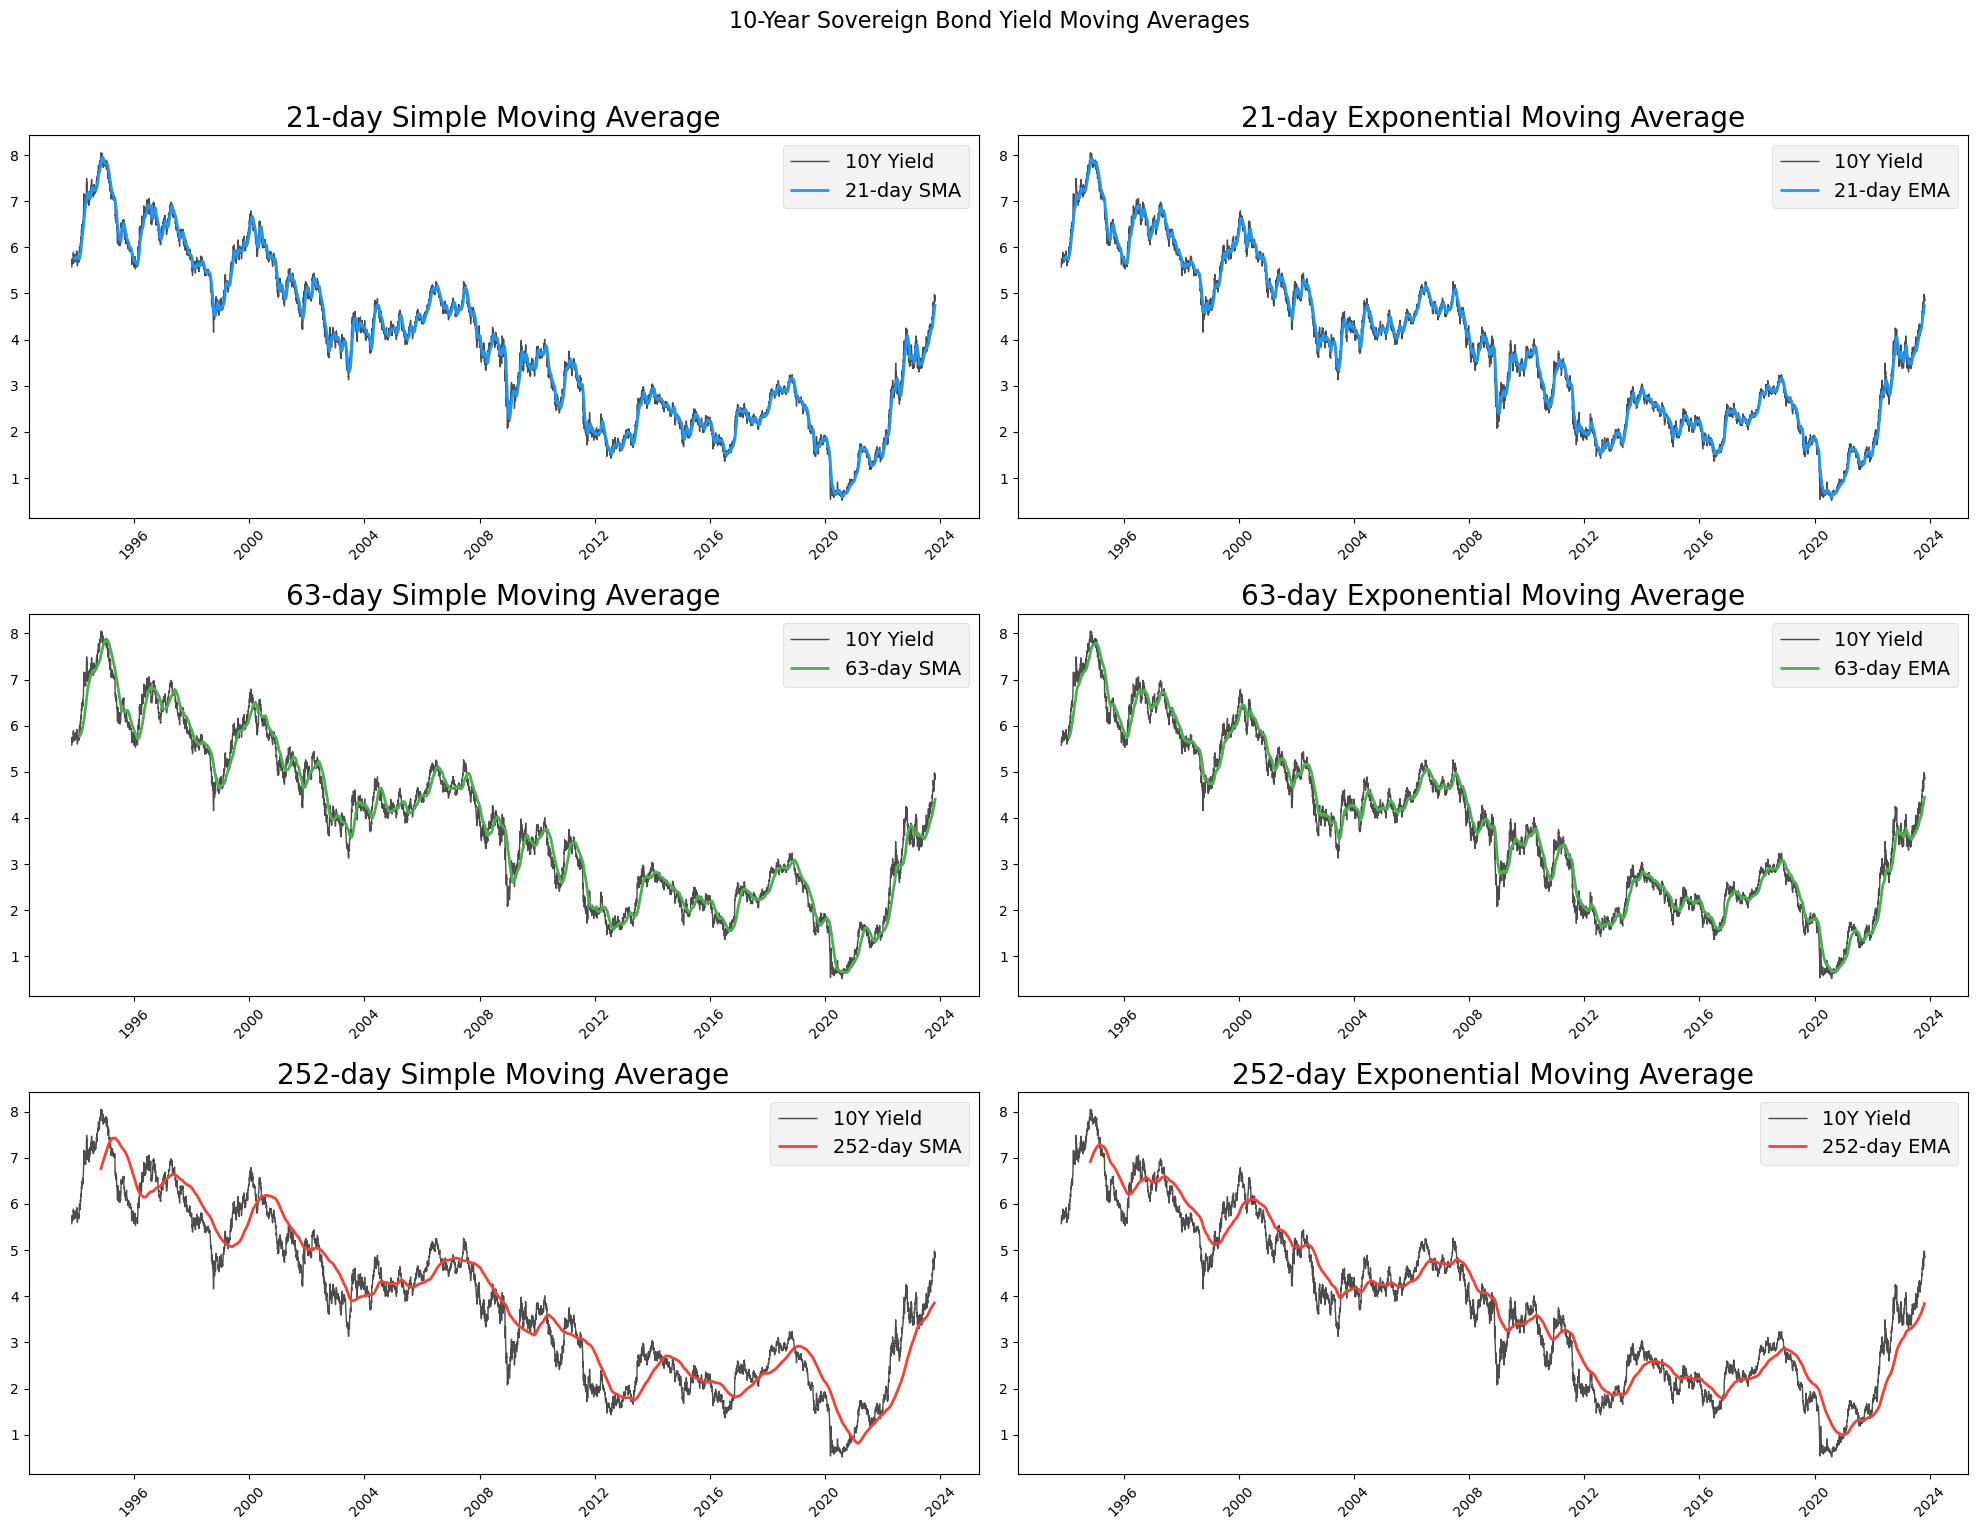

In [71]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
plt.style.use('fivethirtyeight')

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot data
# 1. SMA 21
axes[0].plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[0].plot(df.index, df['sma_21'], label='21-day SMA', color='#2196F3', linewidth=2)
axes[0].set_title('21-day Simple Moving Average')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. EMA 21
axes[1].plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[1].plot(df.index, df['ema_21'], label='21-day EMA', color='#2196F3', linewidth=2)
axes[1].set_title('21-day Exponential Moving Average')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. SMA 63
axes[2].plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[2].plot(df.index, df['sma_63'], label='63-day SMA', color='#4CAF50', linewidth=2)
axes[2].set_title('63-day Simple Moving Average')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# 4. EMA 63
axes[3].plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[3].plot(df.index, df['ema_63'], label='63-day EMA', color='#4CAF50', linewidth=2)
axes[3].set_title('63-day Exponential Moving Average')
axes[3].legend()
axes[3].tick_params(axis='x', rotation=45)

# 5. SMA 252
axes[4].plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[4].plot(df.index, df['sma_252'], label='252-day SMA', color='#F44336', linewidth=2)
axes[4].set_title('252-day Simple Moving Average')
axes[4].legend()
axes[4].tick_params(axis='x', rotation=45)

# 6. EMA 252
axes[5].plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[5].plot(df.index, df['ema_252'], label='252-day EMA', color='#F44336', linewidth=2)
axes[5].set_title('252-day Exponential Moving Average')
axes[5].legend()
axes[5].tick_params(axis='x', rotation=45)

# Add main title
fig.suptitle('10-Year Sovereign Bond Yield Moving Averages', fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [72]:
# 21 day normal rsi and stochastic rsi calculator
df['rsi_21'] = RSIIndicator(close=df['yield_10y'], window=21).rsi()

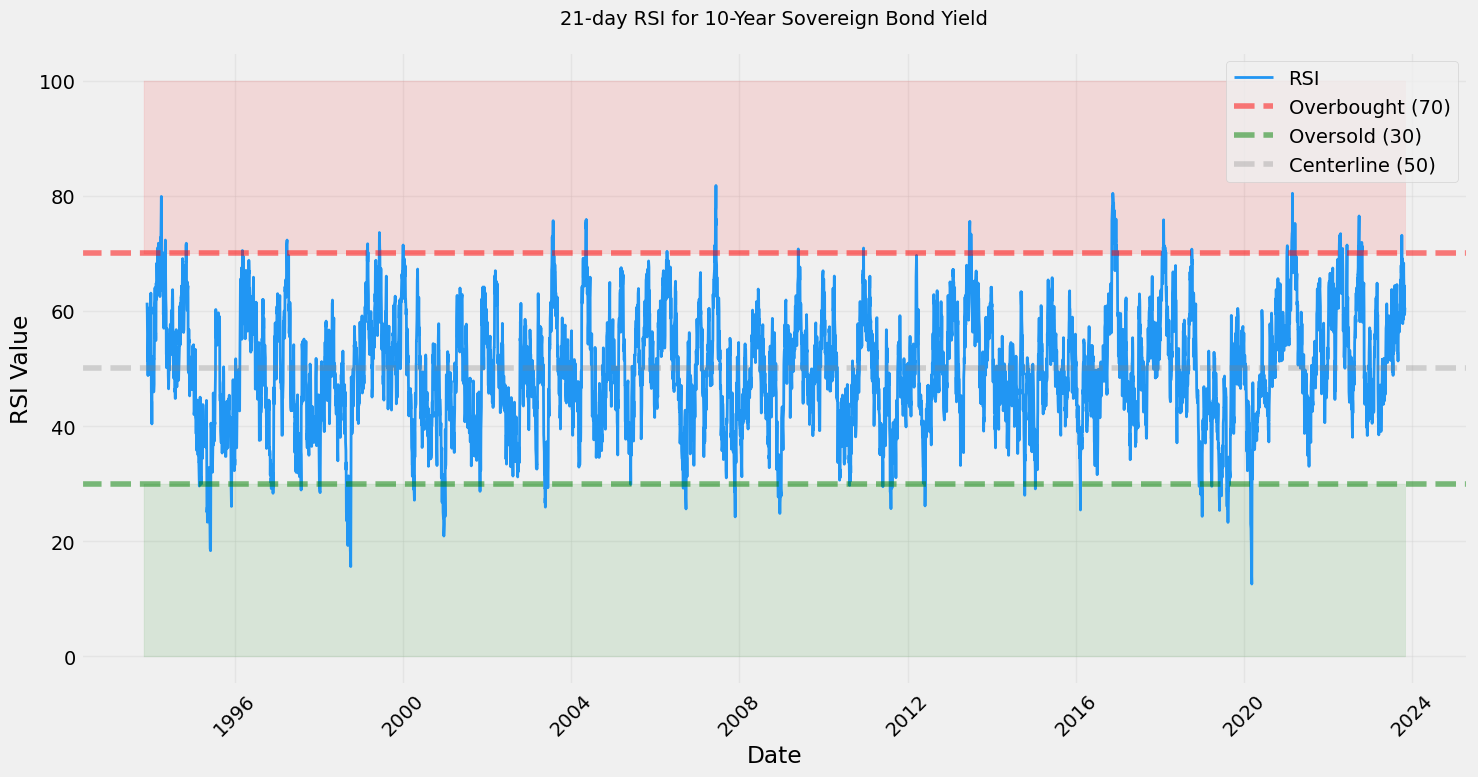

In [73]:
# Create figure
plt.figure(figsize=(15, 8))
plt.style.use('fivethirtyeight')

# Plot RSI
plt.plot(df.index, df['rsi_21'], color='#2196F3', linewidth=2, label='RSI')

# Add title and labels
plt.title('21-day RSI for 10-Year Sovereign Bond Yield', fontsize=14, pad=20)
plt.ylabel('RSI Value')
plt.xlabel('Date')

# Add RSI bands
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.3, label='Centerline (50)')

# Fill overbought/oversold regions
plt.fill_between(df.index, 70, 100, color='r', alpha=0.1)
plt.fill_between(df.index, 0, 30, color='g', alpha=0.1)

# Customize x-axis
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Add grid
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [74]:
# moving average convergence divergence
macd = MACD(close=df['yield_10y'], window_slow=63, window_fast=21, window_sign=21)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_hist'] = macd.macd_diff()

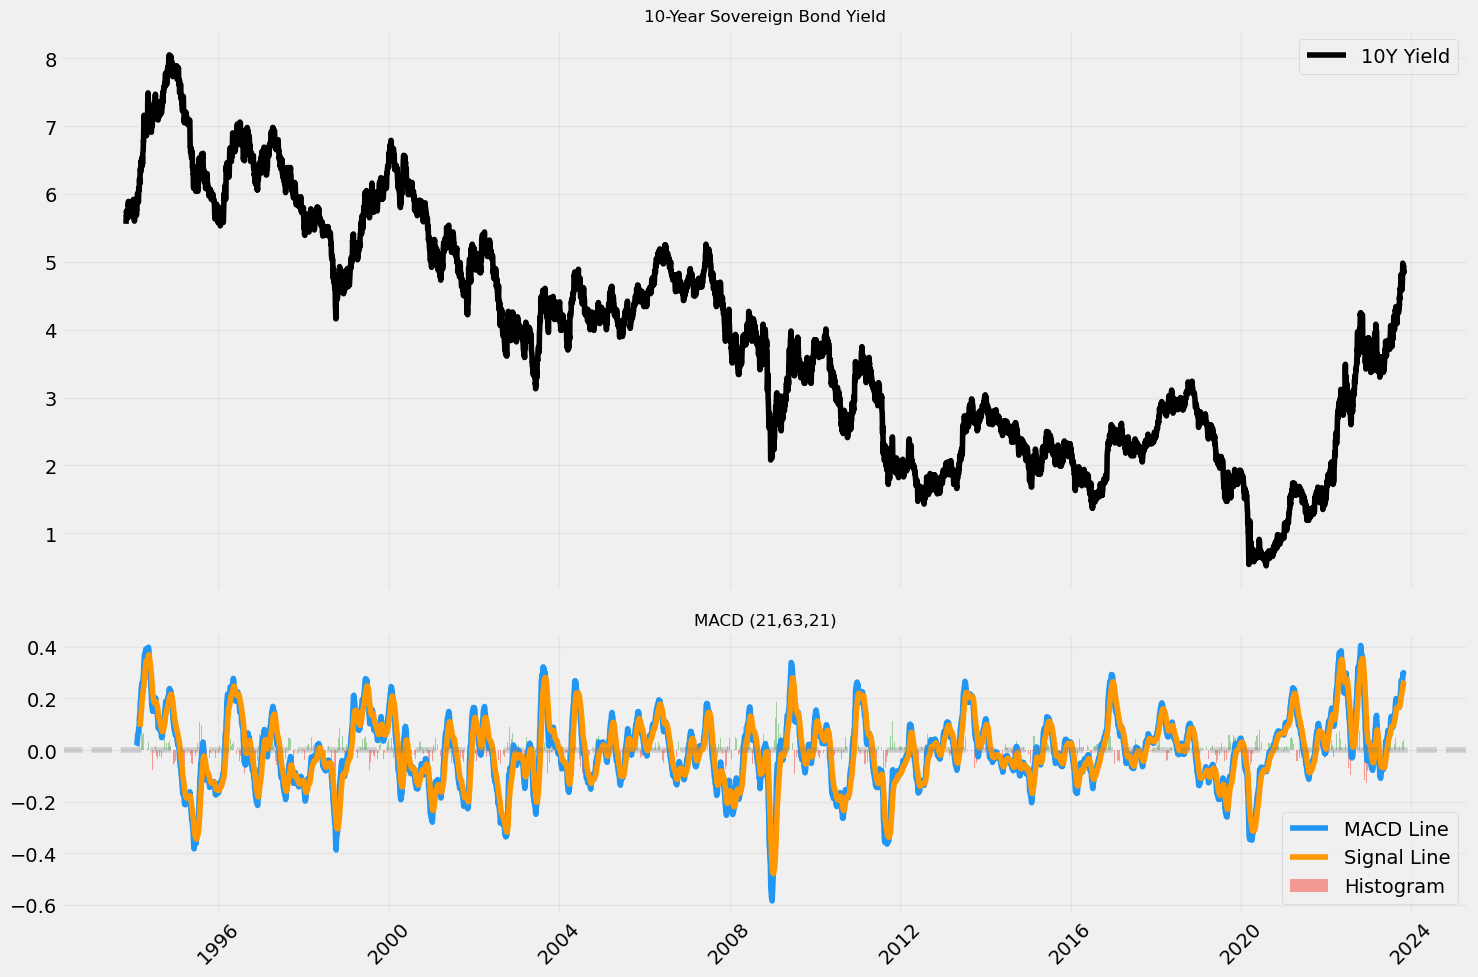

In [75]:
# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1], sharex=True)
plt.style.use('fivethirtyeight')

# Plot yield in top subplot
ax1.plot(df.index, df['yield_10y'], color='black', label='10Y Yield')
ax1.set_title('10-Year Sovereign Bond Yield', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot MACD components in bottom subplot
ax2.plot(df.index, df['macd'], color='#2196F3', label='MACD Line')
ax2.plot(df.index, df['macd_signal'], color='#FF9800', label='Signal Line')

# Plot histogram
colors = ['#4CAF50' if val >= 0 else '#F44336' for val in df['macd_hist']]
ax2.bar(df.index, df['macd_hist'], color=colors, label='Histogram', alpha=0.5)

# Add horizontal line at 0
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Customize bottom subplot
ax2.set_title('MACD (21,63,21)', fontsize=12)  # Updated title to reflect new windows
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [76]:
# Bollinger bands calculation
bb = BollingerBands(close=df['yield_10y'], window=63, window_dev=2)
df['bb_mavg'] = bb.bollinger_mavg()
df['bb_hband'] = bb.bollinger_hband()
df['bb_lband'] = bb.bollinger_lband()
df['bb_pband'] = bb.bollinger_pband()
df['bb_wband'] = bb.bollinger_wband()

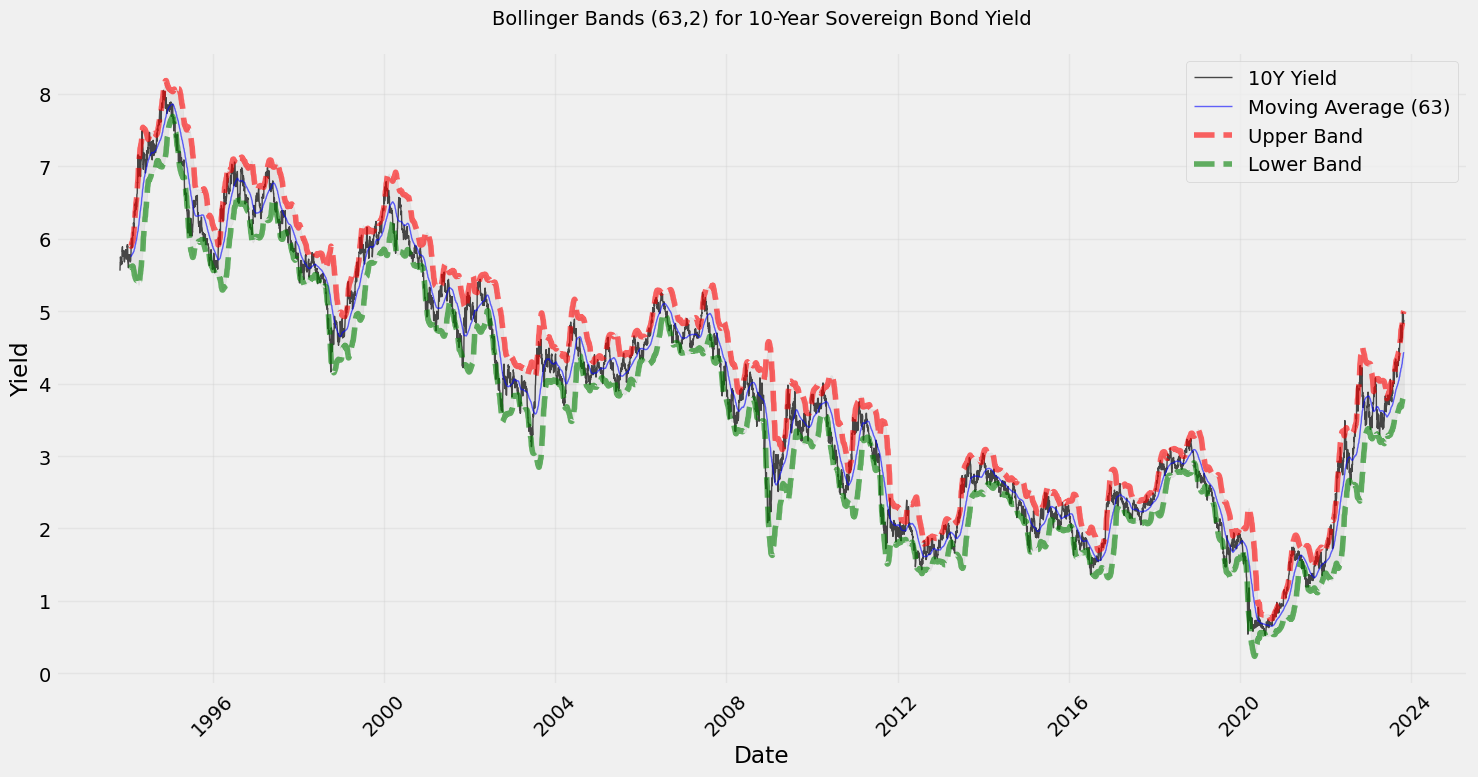

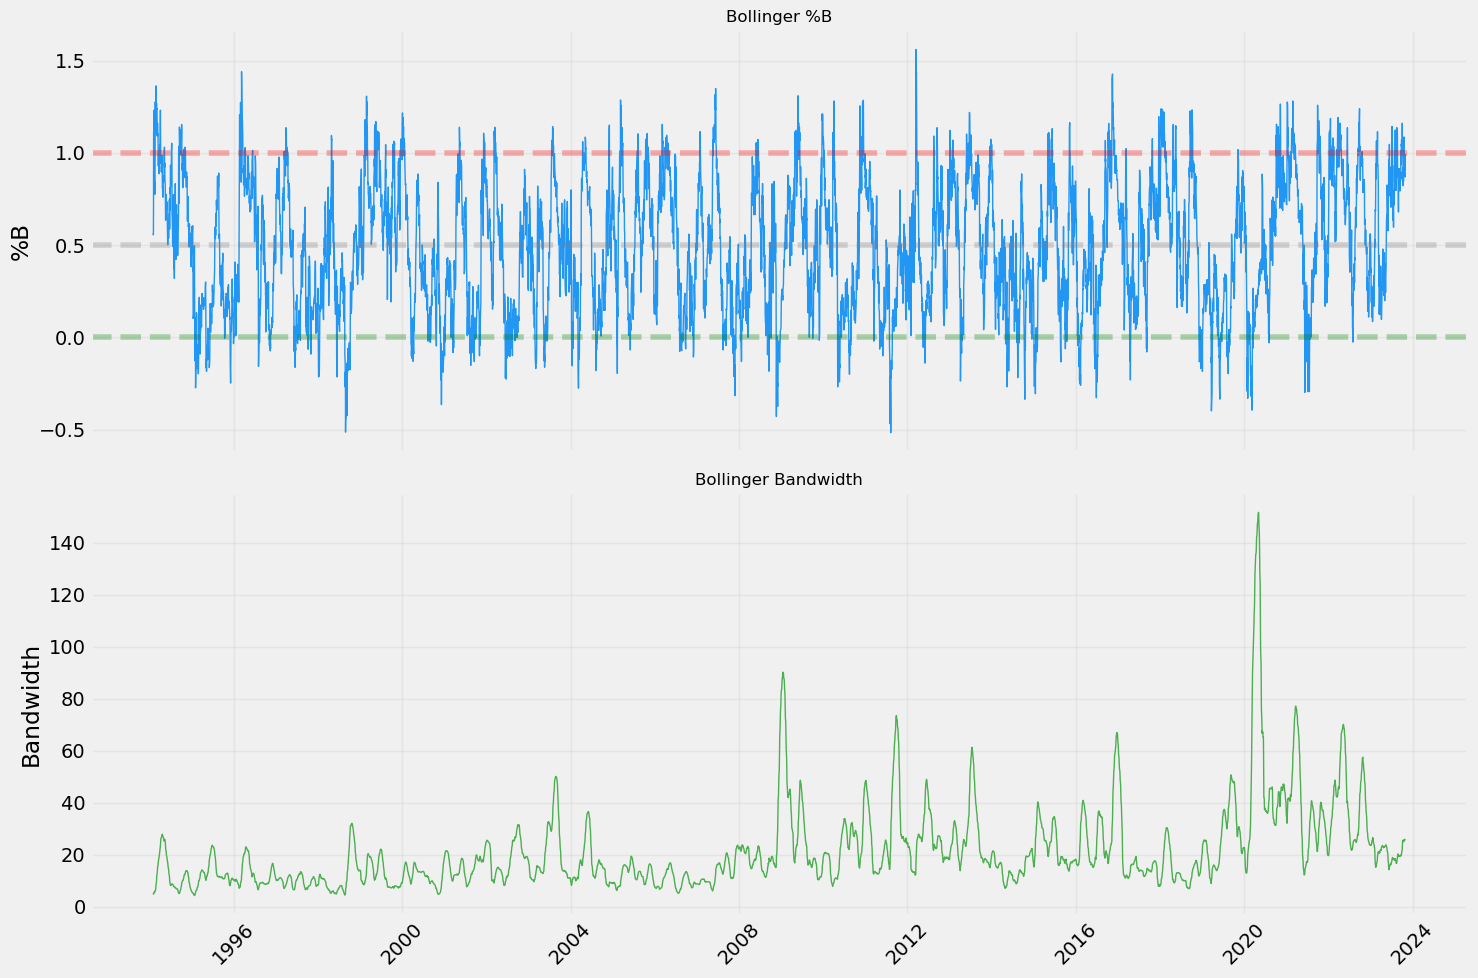

In [77]:
# Create figure
plt.figure(figsize=(15, 8))
plt.style.use('fivethirtyeight')

# Plot yield
plt.plot(df.index, df['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)

# Plot Bollinger Bands
plt.plot(df.index, df['bb_mavg'], label='Moving Average (63)', color='blue', alpha=0.6, linewidth=1)
plt.plot(df.index, df['bb_hband'], label='Upper Band', color='red', linestyle='--', alpha=0.6)
plt.plot(df.index, df['bb_lband'], label='Lower Band', color='green', linestyle='--', alpha=0.6)

# Fill between bands
plt.fill_between(df.index, df['bb_hband'], df['bb_lband'], alpha=0.1, color='gray')

# Add title and labels
plt.title('Bollinger Bands (63,2) for 10-Year Sovereign Bond Yield', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Yield')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add grid
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Create a second figure for %B and Bandwidth
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot %B (Bollinger Percent)
ax1.plot(df.index, df['bb_pband'], color='#2196F3', linewidth=1)
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.3)
ax1.axhline(y=0, color='green', linestyle='--', alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
ax1.set_title('Bollinger %B', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('%B')

# Plot Bandwidth
ax2.plot(df.index, df['bb_wband'], color='#4CAF50', linewidth=1)
ax2.set_title('Bollinger Bandwidth', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylabel('Bandwidth')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [78]:
# ichimoku kinko hyo
tenkan_window = 21
kijun_window = 63
senkou_window = 252

df['tenkan_sen'] = (df['yield_10y'].rolling(window=tenkan_window).max() + df['yield_10y'].rolling(window=tenkan_window).min()) / 2
df['kijun_sen'] = (df['yield_10y'].rolling(window=kijun_window).max() + df['yield_10y'].rolling(window=kijun_window).min()) / 2
df['senkou_span_a'] = (df['tenkan_sen'] + df['kijun_sen']) / 2
df['senkou_span_b'] = (df['yield_10y'].rolling(window=senkou_window).max() + df['yield_10y'].rolling(window=senkou_window).min()) / 2

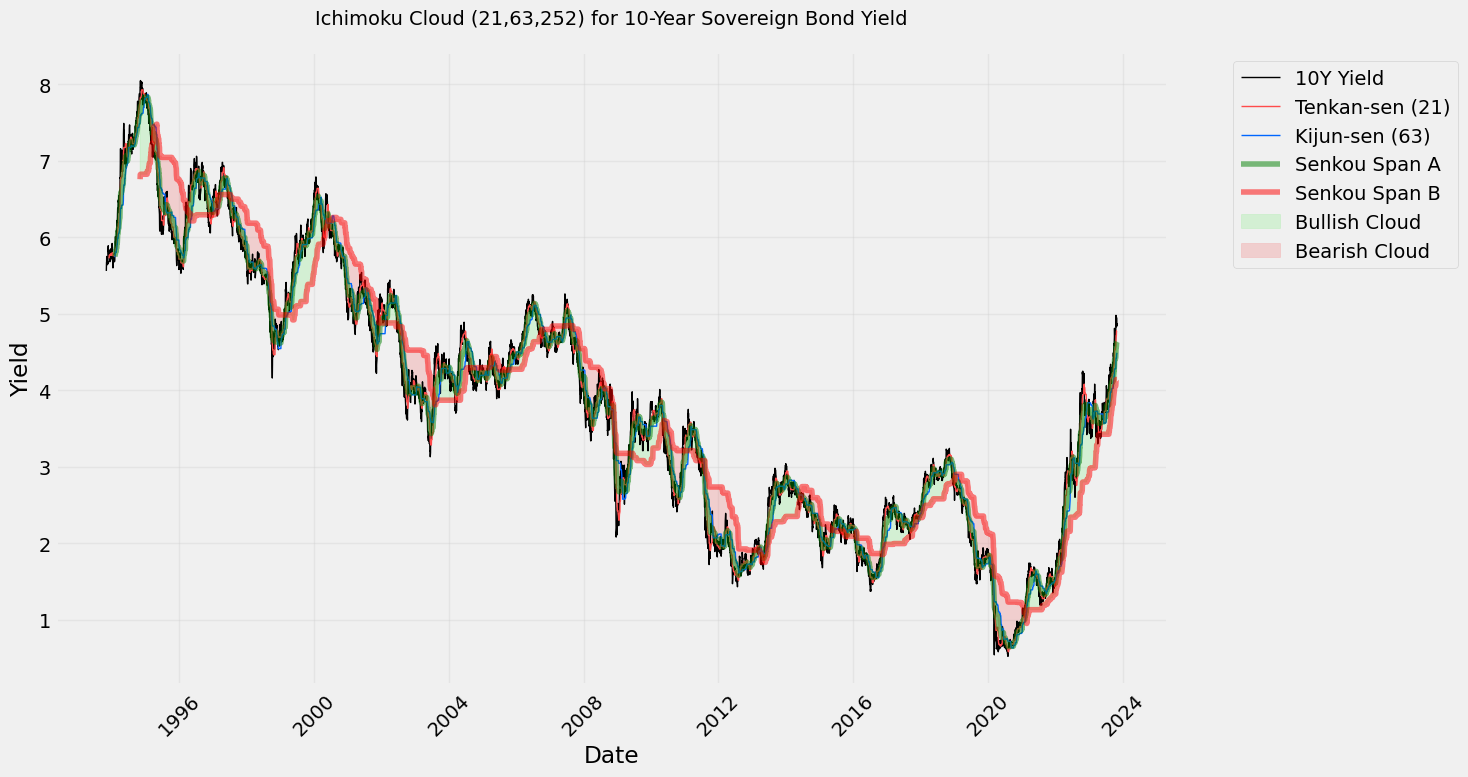

In [79]:
# Create figure
plt.figure(figsize=(15, 8))
plt.style.use('fivethirtyeight')

# Plot yield
plt.plot(df.index, df['yield_10y'], label='10Y Yield', color='black', linewidth=1)

# Plot Ichimoku components
plt.plot(df.index, df['tenkan_sen'], label='Tenkan-sen (21)', color='#FF4B4B', linewidth=1)
plt.plot(df.index, df['kijun_sen'], label='Kijun-sen (63)', color='#0066FF', linewidth=1)

# Plot and fill the cloud
plt.plot(df.index, df['senkou_span_a'], label='Senkou Span A', color='green', alpha=0.5)
plt.plot(df.index, df['senkou_span_b'], label='Senkou Span B', color='red', alpha=0.5)

# Fill between Senkou Span A and B (the cloud)
plt.fill_between(df.index, 
                 df['senkou_span_a'], 
                 df['senkou_span_b'], 
                 where=df['senkou_span_a'] >= df['senkou_span_b'], 
                 color='lightgreen', 
                 alpha=0.3,
                 label='Bullish Cloud')

plt.fill_between(df.index, 
                 df['senkou_span_a'], 
                 df['senkou_span_b'], 
                 where=df['senkou_span_a'] < df['senkou_span_b'], 
                 color='lightcoral', 
                 alpha=0.3,
                 label='Bearish Cloud')

# Add title and labels
plt.title('Ichimoku Cloud (21,63,252) for 10-Year Sovereign Bond Yield', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Yield')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add grid
plt.grid(True, alpha=0.3)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [80]:
# creating lagged features
df['yield_10y_lag1'] = df['yield_10y'].shift(1)
df['yield_10y_lag21'] = df['yield_10y'].shift(21)
df['yield_10y_lag63'] = df['yield_10y'].shift(63)
df['yield_10y_lag252'] = df['yield_10y'].shift(252)

# differences over various horizons
df['yield_10y_diff1'] = df['yield_10y'].diff(1)
df['yield_10y_diff21'] = df['yield_10y'].diff(21)
df['yield_10y_diff63'] = df['yield_10y'].diff(63)
df['yield_10y_diff252'] = df['yield_10y'].diff(252)

# rolling vols
df['roll_std_21'] = df['yield_10y'].rolling(window=21).std()
df['roll_std_63'] = df['yield_10y'].rolling(window=63).std()
df['roll_std_252'] = df['yield_10y'].rolling(window=252).std()

df = df.dropna()
df

,yield_10y,sma_21,ema_21,sma_63,ema_63,sma_252,ema_252,rsi_21,macd,macd_signal,...,yield_10y_lag21,yield_10y_lag63,yield_10y_lag252,yield_10y_diff1,yield_10y_diff21,yield_10y_diff63,yield_10y_diff252,roll_std_21,roll_std_63,roll_std_252
Date,,,,,,,,,,,,,,,,,,,,,
1994-11-03,7.96,7.778571,7.786832,7.512540,7.567314,6.749206,6.898213,68.502894,0.219517,0.187823,...,7.70,7.12,5.56,0.00,0.26,0.84,2.40,0.113370,0.237419,0.719751
1994-11-04,8.04,7.791429,7.809847,7.524603,7.582086,6.758770,6.907239,71.404963,0.227761,0.191454,...,7.77,7.28,5.63,0.08,0.27,0.76,2.41,0.126858,0.244612,0.720831
1994-11-07,8.05,7.804286,7.831679,7.536825,7.596708,6.768214,6.916273,71.746632,0.234971,0.195410,...,7.78,7.28,5.67,0.01,0.27,0.77,2.38,0.138765,0.251337,0.722099
1994-11-08,8.01,7.819048,7.847890,7.547619,7.609624,6.777500,6.924919,68.318155,0.238266,0.199306,...,7.70,7.33,5.67,-0.04,0.31,0.68,2.34,0.143524,0.256853,0.722966
1994-11-09,7.94,7.832857,7.856264,7.557778,7.619948,6.786190,6.932943,62.803586,0.236316,0.202671,...,7.65,7.30,5.75,-0.07,0.29,0.64,2.19,0.140362,0.259543,0.723727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,4.83,4.726190,4.714664,4.374444,4.419372,3.863770,3.835884,60.948134,0.295293,0.256093,...,4.44,3.91,4.14,-0.03,0.39,0.92,0.69,0.129556,0.284332,0.377678
2023-10-25,4.95,4.745238,4.736059,4.391746,4.435954,3.866587,3.844691,64.358216,0.300105,0.260094,...,4.55,3.86,4.24,0.12,0.40,1.09,0.71,0.131743,0.285683,0.383105
2023-10-26,4.86,4.759524,4.747326,4.405238,4.449205,3.869167,3.852718,60.217314,0.298120,0.263551,...,4.56,4.01,4.21,-0.09,0.30,0.85,0.65,0.126826,0.287429,0.387588


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7241 entries, 1994-11-03 to 2023-10-30
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   yield_10y          7241 non-null   float64
 1   sma_21             7241 non-null   float64
 2   ema_21             7241 non-null   float64
 3   sma_63             7241 non-null   float64
 4   ema_63             7241 non-null   float64
 5   sma_252            7241 non-null   float64
 6   ema_252            7241 non-null   float64
 7   rsi_21             7241 non-null   float64
 8   macd               7241 non-null   float64
 9   macd_signal        7241 non-null   float64
 10  macd_hist          7241 non-null   float64
 11  bb_mavg            7241 non-null   float64
 12  bb_hband           7241 non-null   float64
 13  bb_lband           7241 non-null   float64
 14  bb_pband           7241 non-null   float64
 15  bb_wband           7241 non-null   float64
 16  tenkan

In [82]:
df_macro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inflation          10956 non-null  float64
 1   ppi_mom            10956 non-null  float64
 2   fed_funds_rate     10956 non-null  float64
 3   unemployment_rate  10956 non-null  float64
 4   10_minus_2         7505 non-null   float64
 5   gdp                10956 non-null  float64
dtypes: float64(6)
memory usage: 599.2 KB


In [83]:
df_marco_merge_final = df.join(df_macro_imputed, how='left')
df_marco_merge_final.isna().sum()

yield_10y            0
sma_21               0
ema_21               0
sma_63               0
ema_63               0
sma_252              0
ema_252              0
rsi_21               0
macd                 0
macd_signal          0
macd_hist            0
bb_mavg              0
bb_hband             0
bb_lband             0
bb_pband             0
bb_wband             0
tenkan_sen           0
kijun_sen            0
senkou_span_a        0
senkou_span_b        0
yield_10y_lag1       0
yield_10y_lag21      0
yield_10y_lag63      0
yield_10y_lag252     0
yield_10y_diff1      0
yield_10y_diff21     0
yield_10y_diff63     0
yield_10y_diff252    0
roll_std_21          0
roll_std_63          0
roll_std_252         0
inflation            0
ppi_mom              0
fed_funds_rate       0
unemployment_rate    0
gdp                  0
10_minus_2           0
dtype: int64

# 3) Feature Selection

In [84]:
target = 'yield_10y'
X = df_marco_merge_final.drop(columns=[target])
y = df_marco_merge_final[target]

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

c:\Users\yadve\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


              feature           VIF
12           bb_lband           inf
24   yield_10y_diff21           inf
22   yield_10y_lag252           inf
21    yield_10y_lag63           inf
20    yield_10y_lag21           inf
19     yield_10y_lag1           inf
1              ema_21           inf
17      senkou_span_a           inf
16          kijun_sen           inf
15         tenkan_sen           inf
25   yield_10y_diff63           inf
26  yield_10y_diff252           inf
23    yield_10y_diff1           inf
11           bb_hband           inf
10            bb_mavg           inf
9           macd_hist           inf
8         macd_signal           inf
7                macd           inf
28        roll_std_63           inf
3              ema_63           inf
2              sma_63           inf
0              sma_21  8.569930e+04
5             ema_252  6.740540e+03
4             sma_252  4.488761e+03
18      senkou_span_b  2.002530e+03
6              rsi_21  7.155273e+01
32     fed_funds_rate  5.868

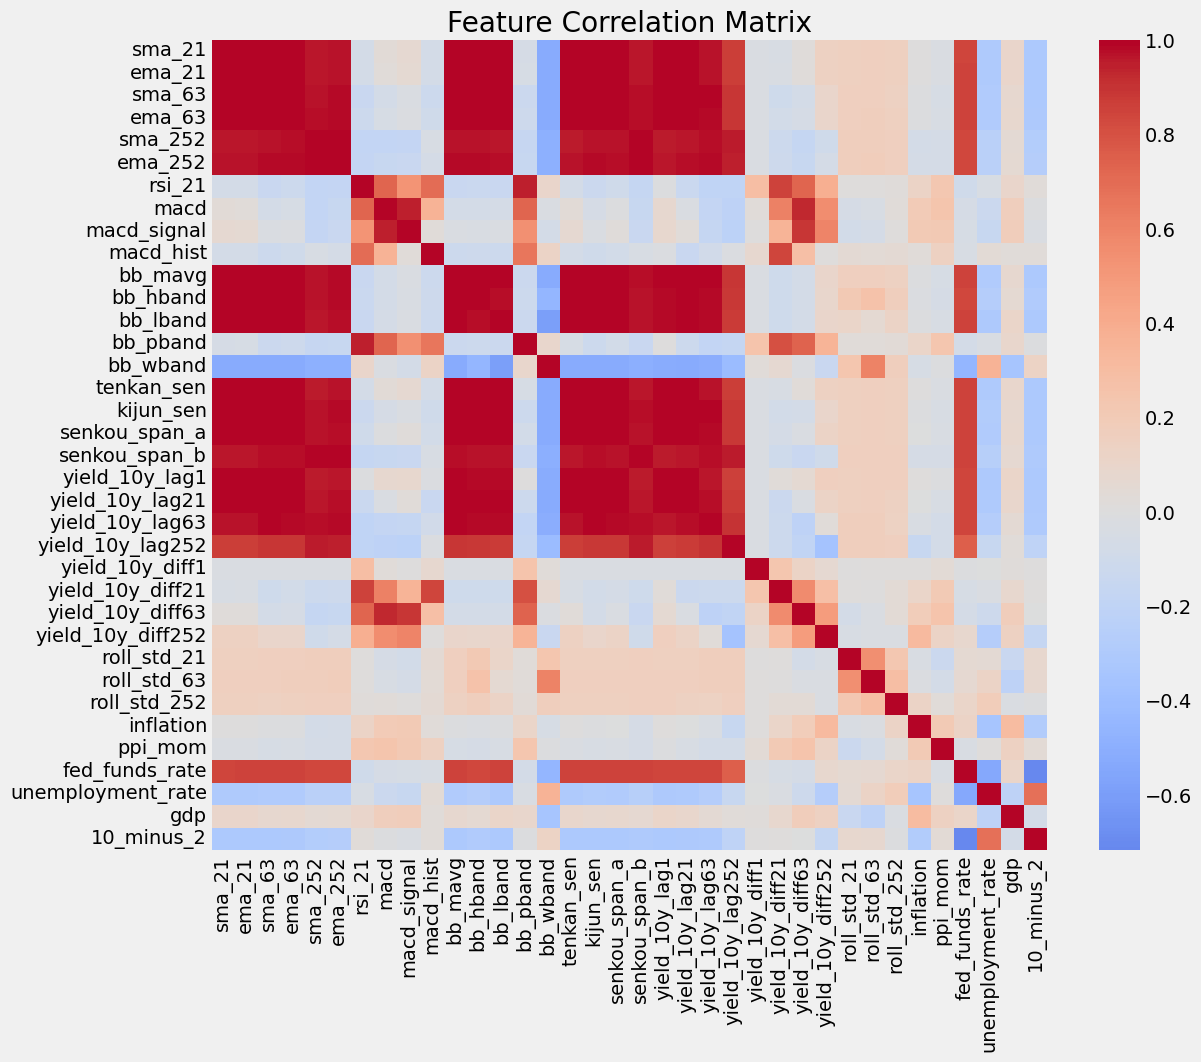

Highly correlated feature pairs: [('sma_21', 'sma_63'), ('sma_21', 'sma_252'), ('sma_21', 'tenkan_sen'), ('sma_21', 'yield_10y_lag1'), ('sma_21', 'yield_10y_lag21'), ('sma_21', 'yield_10y_lag63'), ('ema_21', 'sma_21'), ('ema_21', 'sma_63'), ('ema_21', 'ema_63'), ('ema_21', 'sma_252'), ('ema_21', 'ema_252'), ('ema_21', 'tenkan_sen'), ('ema_21', 'kijun_sen'), ('ema_21', 'senkou_span_a'), ('ema_21', 'senkou_span_b'), ('ema_21', 'yield_10y_lag1'), ('ema_21', 'yield_10y_lag21'), ('ema_21', 'yield_10y_lag63'), ('sma_63', 'tenkan_sen'), ('sma_63', 'yield_10y_lag1'), ('sma_63', 'yield_10y_lag21'), ('sma_63', 'yield_10y_lag63'), ('ema_63', 'sma_21'), ('ema_63', 'sma_63'), ('ema_63', 'sma_252'), ('ema_63', 'tenkan_sen'), ('ema_63', 'kijun_sen'), ('ema_63', 'senkou_span_a'), ('ema_63', 'senkou_span_b'), ('ema_63', 'yield_10y_lag1'), ('ema_63', 'yield_10y_lag21'), ('ema_63', 'yield_10y_lag63'), ('sma_252', 'sma_63'), ('sma_252', 'tenkan_sen'), ('sma_252', 'yield_10y_lag1'), ('sma_252', 'yield_10y_

In [87]:
import seaborn as sns
corr = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Identify pairs of features with high correlation
high_corr_pairs = [(c1, c2) for c1 in corr.columns for c2 in corr.columns 
                   if c1 < c2 and abs(corr.loc[c1, c2]) > 0.9]
print("Highly correlated feature pairs:", high_corr_pairs)

In [88]:
corr_with_target = X.corrwith(y)
print(corr_with_target.sort_values(ascending=False))

yield_10y_lag1       0.999380
ema_21               0.997156
tenkan_sen           0.996542
sma_21               0.996204
senkou_span_a        0.994235
ema_63               0.990693
kijun_sen            0.989283
sma_63               0.987434
bb_mavg              0.987434
yield_10y_lag21      0.987432
bb_hband             0.982704
bb_lband             0.981978
ema_252              0.964911
yield_10y_lag63      0.962512
senkou_span_b        0.957441
sma_252              0.952549
yield_10y_lag252     0.864056
fed_funds_rate       0.843178
yield_10y_diff252    0.163175
roll_std_63          0.160734
roll_std_252         0.156268
roll_std_21          0.154156
gdp                  0.102326
macd_signal          0.082767
macd                 0.073688
yield_10y_diff63     0.061595
yield_10y_diff21     0.029747
inflation            0.013298
bb_pband             0.013081
yield_10y_diff1      0.005836
rsi_21               0.000388
ppi_mom             -0.008411
macd_hist           -0.010894
unemployme

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Initialize a model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Check feature importances
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importances)

yield_10y_lag1       0.996252
yield_10y_diff1      0.000982
sma_21               0.000617
ema_63               0.000453
tenkan_sen           0.000405
ema_21               0.000341
kijun_sen            0.000247
senkou_span_a        0.000124
yield_10y_diff63     0.000087
sma_63               0.000073
yield_10y_diff252    0.000051
bb_hband             0.000046
10_minus_2           0.000045
bb_lband             0.000044
yield_10y_lag21      0.000042
rsi_21               0.000032
sma_252              0.000016
macd                 0.000015
macd_signal          0.000015
roll_std_252         0.000014
bb_pband             0.000014
ema_252              0.000012
unemployment_rate    0.000009
senkou_span_b        0.000008
roll_std_21          0.000008
roll_std_63          0.000007
yield_10y_diff21     0.000007
macd_hist            0.000006
bb_wband             0.000006
yield_10y_lag252     0.000005
ppi_mom              0.000004
yield_10y_lag63      0.000004
inflation            0.000004
gdp       

In [90]:
# Select top k features
k = 10
top_features = feature_importances.index[:k]
X_selected = X[top_features]

# Alternatively, use SelectFromModel to automatically choose features
selector = SelectFromModel(model, threshold="median")  # select features above the median importance
X_selected_auto = selector.fit_transform(X, y)

# 4) Regime Modeling

## using hidden markov models for regime detection

In [91]:
from hmmlearn.hmm import GaussianHMM
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [92]:
df['returns'] = df['yield_10y'].pct_change()
df['rolling_vol'] = df['returns'].rolling(window=21).std()
df['annualized_vol'] = df['rolling_vol'] * np.sqrt(252)

# Drop initial rows with NaNs due to rolling calculations
df = df.dropna(subset=['returns', 'rolling_vol', 'annualized_vol'])

In [93]:
X_hmm = df[['returns', 'annualized_vol']].values

In [94]:
model_hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
model_hmm.fit(X_hmm)

# Predict hidden states
hidden_states = model_hmm.predict(X_hmm)
df['hidden_state'] = hidden_states

C:\Users\yadve\AppData\Local\Temp\ipykernel_161192\3603189081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hidden_state'] = hidden_states


In [95]:
state_vol_means = []
for state in range(model_hmm.n_components):
    mask = (df['hidden_state'] == state)
    state_vol_mean = df.loc[mask, 'annualized_vol'].mean()
    state_vol_means.append((state, state_vol_mean))

# Sort states by volatility mean
state_vol_means.sort(key=lambda x: x[1])  # sort by mean vol
# Example: [(state_low, mean_low), (state_neutral, mean_neutral), (state_high, mean_high)]

low_state = state_vol_means[0][0]
high_state = state_vol_means[-1][0]
# The middle one is neutral
neutral_state = state_vol_means[1][0]

# Map states to regime labels
def map_state_to_regime(state):
    if state == low_state:
        return 'Low Volatility'
    elif state == high_state:
        return 'High Volatility'
    else:
        return 'Neutral Volatility'

df['vol_regime'] = df['hidden_state'].apply(map_state_to_regime)


C:\Users\yadve\AppData\Local\Temp\ipykernel_161192\3096421767.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol_regime'] = df['hidden_state'].apply(map_state_to_regime)


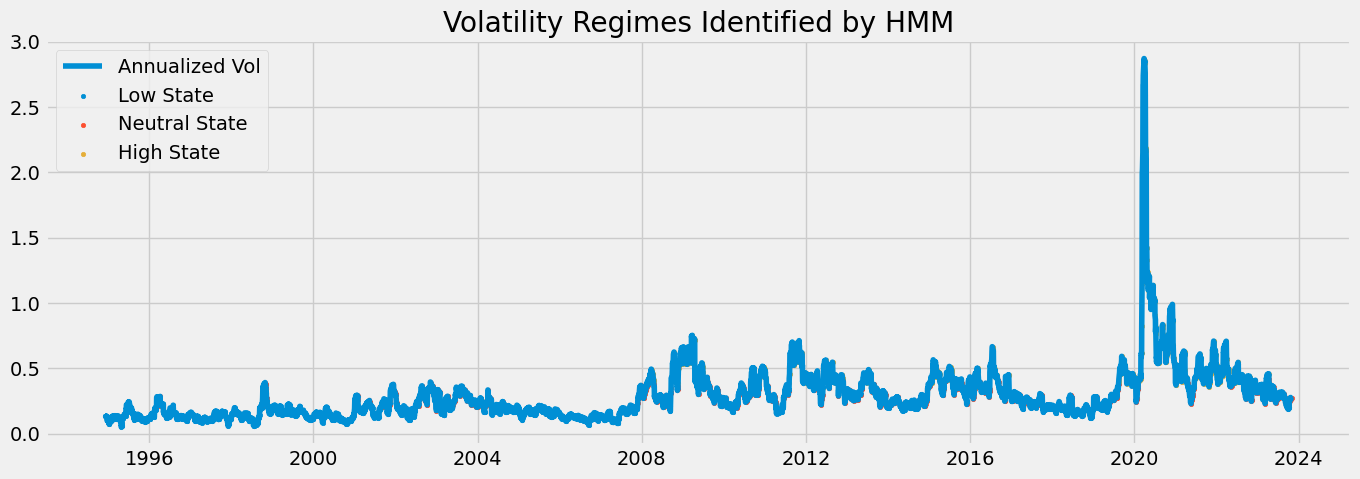

In [96]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['annualized_vol'], label='Annualized Vol')
for state, label in zip([low_state, neutral_state, high_state], ['Low', 'Neutral', 'High']):
    plt.scatter(df[df['hidden_state']==state].index, df[df['hidden_state']==state]['annualized_vol'],
                label=label + ' State', s=10)
plt.legend()
plt.title('Volatility Regimes Identified by HMM')
plt.show()

## 2019 segregation

In [97]:
# Assume df is your original DataFrame with a DatetimeIndex
train_df = df[:'2018-12-31']
test_df = df['2019-01-01':]

In [98]:
# Calculate returns and volatility on training data
train_df['returns'] = train_df['yield_10y'].pct_change()
train_df['rolling_vol'] = train_df['returns'].rolling(window=21).std()
train_df['annualized_vol'] = train_df['rolling_vol'] * np.sqrt(252)
train_df = train_df.dropna(subset=['annualized_vol'])

# Prepare data for HMM
X_hmm = train_df[['returns', 'annualized_vol']].values

from hmmlearn.hmm import GaussianHMM

# Fit HMM with 2 hidden states
model_hmm_2 = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
X_hmm = train_df[['returns', 'annualized_vol']].dropna().values
model_hmm_2.fit(X_hmm)
hidden_states_2 = model_hmm_2.predict(X_hmm)

train_df = train_df.dropna(subset=['returns', 'annualized_vol'])
train_df['hidden_state_2'] = hidden_states_2

# Identify which state has higher mean volatility
state_vol_means_2 = []
for s in range(model_hmm_2.n_components):
    s_mean = train_df.loc[train_df['hidden_state_2'] == s, 'annualized_vol'].mean()
    state_vol_means_2.append((s, s_mean))

state_vol_means_2.sort(key=lambda x: x[1])  # sort by mean vol
low_state = state_vol_means_2[0][0]
high_state = state_vol_means_2[1][0]

def map_state_to_regime_2(state):
    return 'High Volatility' if state == high_state else 'Low Volatility'

train_df['vol_regime_2'] = train_df['hidden_state_2'].apply(map_state_to_regime_2)

C:\Users\yadve\AppData\Local\Temp\ipykernel_161192\954970543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['returns'] = train_df['yield_10y'].pct_change()
C:\Users\yadve\AppData\Local\Temp\ipykernel_161192\954970543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['rolling_vol'] = train_df['returns'].rolling(window=21).std()
C:\Users\yadve\AppData\Local\Temp\ipykernel_161192\954970543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

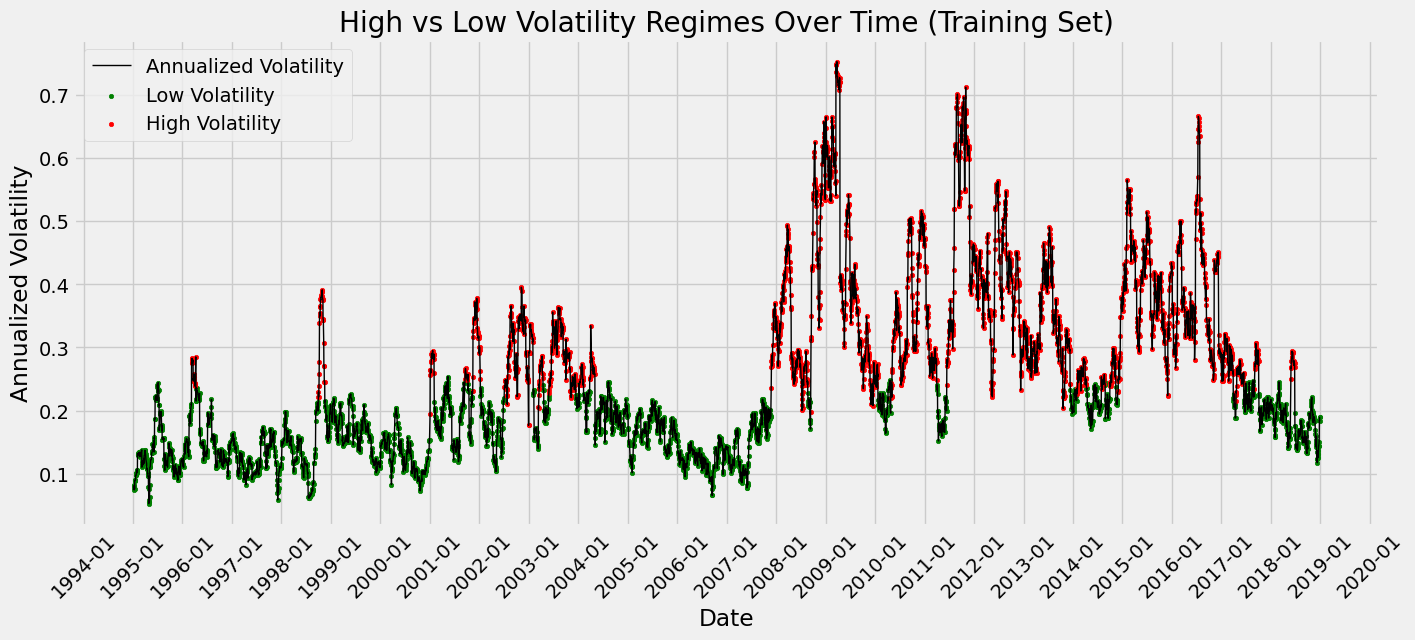

In [99]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(train_df.index, train_df['annualized_vol'], color='black', lw=1, label='Annualized Volatility')

low_vol_df = train_df[train_df['vol_regime_2'] == 'Low Volatility']
high_vol_df = train_df[train_df['vol_regime_2'] == 'High Volatility']

ax.scatter(low_vol_df.index, low_vol_df['annualized_vol'], color='green', s=10, label='Low Volatility')
ax.scatter(high_vol_df.index, high_vol_df['annualized_vol'], color='red', s=10, label='High Volatility')

ax.set_title('High vs Low Volatility Regimes Over Time (Training Set)')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility')
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.show()

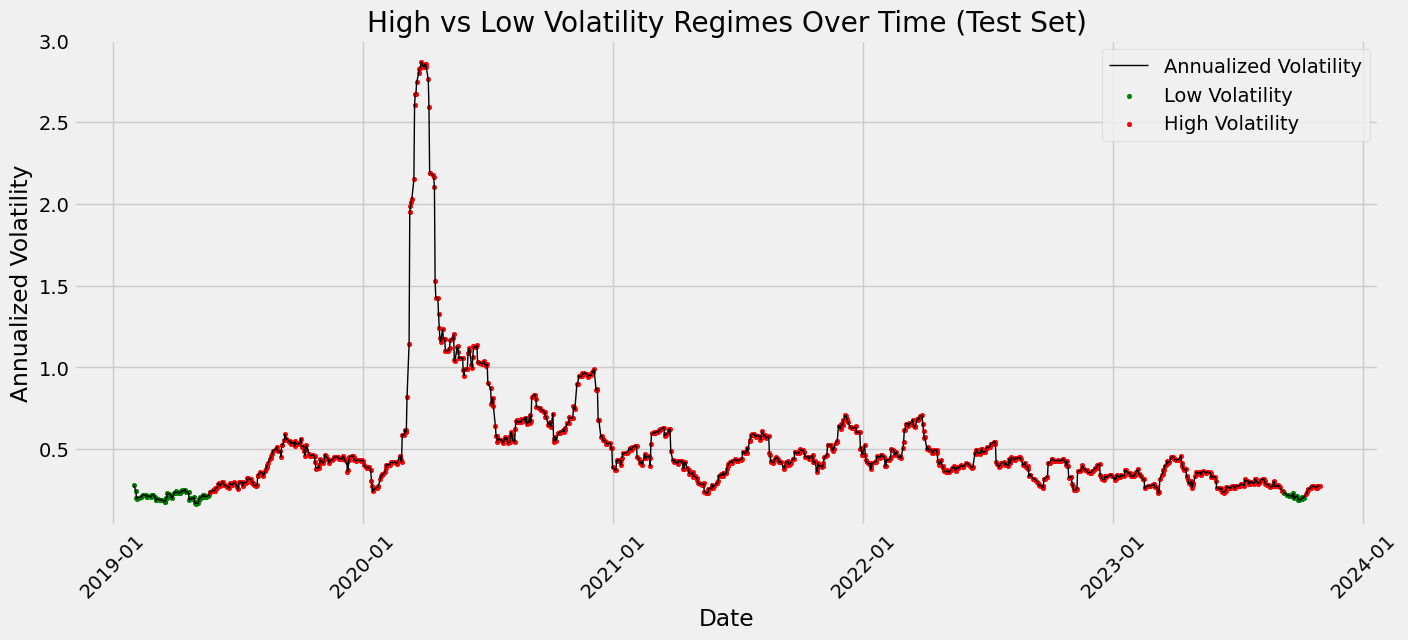

In [100]:
# Compute returns and volatility on the test set (just as in training)
test_df = test_df.copy()  # to avoid SettingWithCopyWarning
test_df['returns'] = test_df['yield_10y'].pct_change()
test_df['rolling_vol'] = test_df['returns'].rolling(window=21).std()
test_df['annualized_vol'] = test_df['rolling_vol'] * np.sqrt(252)

# Drop rows that don't have needed columns
test_df = test_df.dropna(subset=['annualized_vol', 'returns'])

# Prepare features for HMM (same features used in training)
X_test_hmm = test_df[['returns', 'annualized_vol']].values

# Use the already trained HMM from the training set
hidden_states_test = model_hmm_2.predict(X_test_hmm)

# Map states to regimes using the mappings found during training
def map_state_to_regime_2(state):
    return 'High Volatility' if state == high_state else 'Low Volatility'

test_df['hidden_state'] = hidden_states_test
test_df['vol_regime_2'] = test_df['hidden_state'].apply(map_state_to_regime_2)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(test_df.index, test_df['annualized_vol'], color='black', lw=1, label='Annualized Volatility')

low_vol_test = test_df[test_df['vol_regime_2'] == 'Low Volatility']
high_vol_test = test_df[test_df['vol_regime_2'] == 'High Volatility']

ax.scatter(low_vol_test.index, low_vol_test['annualized_vol'], color='green', s=10, label='Low Volatility')
ax.scatter(high_vol_test.index, high_vol_test['annualized_vol'], color='red', s=10, label='High Volatility')

ax.set_title('High vs Low Volatility Regimes Over Time (Test Set)')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility')
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.show()

# 5) Prediction of movement of time-series data

In [106]:
exclude_cols = ['yield_10y', 'returns', 'rolling_vol', 'annualized_vol', 'hidden_state', 'vol_regime']

# Exclude non-numeric columns
df_high_vol = train_df[train_df['vol_regime'] == 'High Volatility']
X_high = df_high_vol.drop(columns=exclude_cols)

# Select only numeric columns for X_high
X_high = X_high.select_dtypes(include='number')

y_high = df_high_vol['yield_10y']

df_low_vol = train_df[train_df['vol_regime'] == 'Low Volatility']
X_low = df_low_vol.drop(columns=exclude_cols)

# Select only numeric columns for X_low
X_low = X_low.select_dtypes(include='number')

y_low = df_low_vol['yield_10y']

from sklearn.ensemble import RandomForestRegressor

def feature_selection(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns)
    top_features = importances.sort_values(ascending=False).head(10).index
    return top_features

# Feature selection for high and low volatility datasets
top_features_high = feature_selection(X_high, y_high)
top_features_low = feature_selection(X_low, y_low)

# Use the selected features for model training
X_high_selected = X_high[top_features_high]
X_low_selected = X_low[top_features_low]

# Fit models
model_high_vol = RandomForestRegressor(n_estimators=100, random_state=42)
model_high_vol.fit(X_high_selected, y_high)

model_low_vol = RandomForestRegressor(n_estimators=100, random_state=42)
model_low_vol.fit(X_low_selected, y_low)

RandomForestRegressor(random_state=42)

In [108]:
test_df = test_df.copy()
test_df['returns'] = test_df['yield_10y'].pct_change()
test_df['rolling_vol'] = test_df['returns'].rolling(window=21).std()
test_df['annualized_vol'] = test_df['rolling_vol'] * np.sqrt(252)
test_df = test_df.dropna(subset=['annualized_vol'])

In [109]:
def detect_regime(data, model_hmm, low_state, high_state):
    data = data.copy().dropna(subset=['returns', 'annualized_vol'])
    X_new = data[['returns', 'annualized_vol']].values[-1:].reshape(1, -1)
    hidden_state = model_hmm.predict(X_new)[0]
    if hidden_state == low_state:
        return 'Low Volatility'
    else:
        return 'High Volatility'

models = {
    'High Volatility': (model_high_vol, top_features_high),
    'Low Volatility': (model_low_vol, top_features_low)
}

predictions = []
regimes = []

for current_date in test_df.index:
    current_data = test_df.loc[:current_date].copy()
    regime = detect_regime(current_data, model_hmm, low_state, high_state)
    model, features = models[regime]
    current_features = current_data[features].iloc[[-1]].dropna(axis=1, how='any')
    pred = model.predict(current_features)[0]
    predictions.append(pred)
    regimes.append(regime)

test_df['predictions'] = predictions
test_df['predicted_regime'] = regimes

RMSE on Test Set: 0.7199975774236963
R-squared on Test Set: 0.6211209542297522


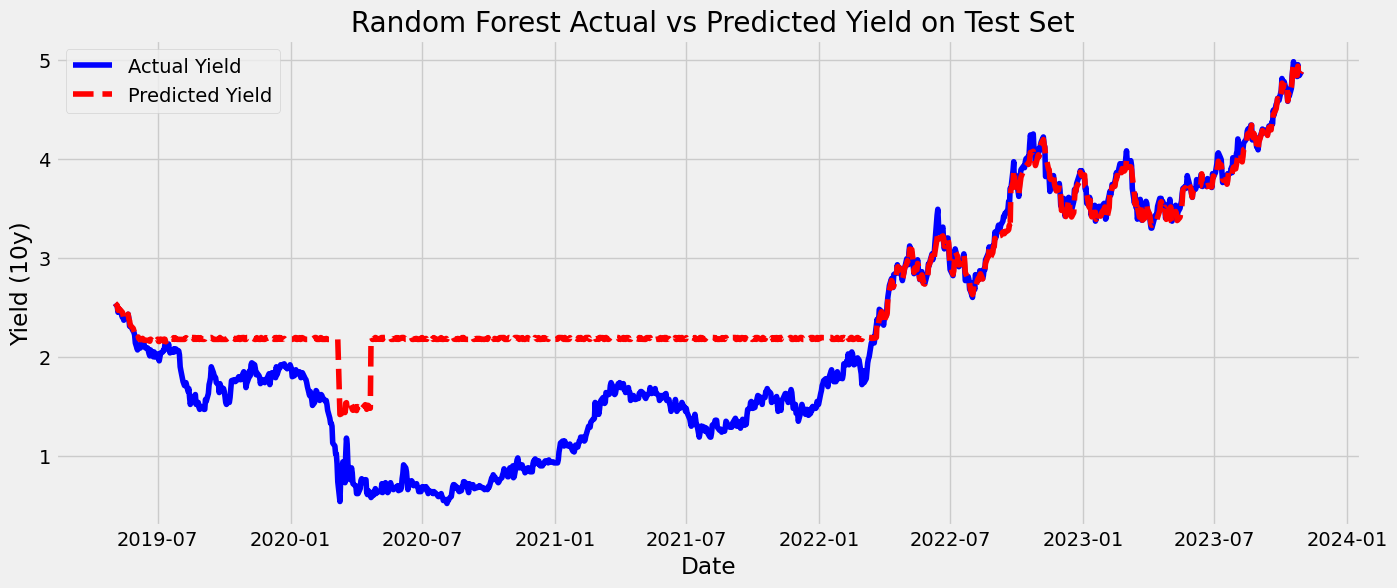

In [111]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(test_df['yield_10y'].iloc[len(predictions)*-1:], test_df['predictions']))
r_squared = r2_score(test_df['yield_10y'].iloc[len(predictions)*-1:], test_df['predictions'])

# Print metrics
print("RMSE on Test Set:", rmse)
print("R-squared on Test Set:", r_squared)

# Plot Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test_df.index, test_df['yield_10y'], label="Actual Yield", color="blue")
plt.plot(test_df.index, test_df['predictions'], label="Predicted Yield", color="red", linestyle="dashed")
plt.title(" Random Forest Actual vs Predicted Yield on Test Set")
plt.xlabel("Date")
plt.ylabel("Yield (10y)")
plt.legend()
plt.show()

In [125]:
def walk_forward_analysis(df, train_months=36, step_months=12, days_per_month=21):
    results = []

    # Calculate train size and step size in terms of days
    train_size_days = train_months * days_per_month
    step_size_days = step_months * days_per_month

    total_len = len(df)
    start_idx = 0

    while start_idx + train_size_days + step_size_days <= total_len:
        train_df = df.iloc[start_idx:start_idx + train_size_days]
        test_df = df.iloc[start_idx + train_size_days:start_idx + train_size_days + step_size_days]

        # Train and detect regimes
        hmm_features = ['returns', 'annualized_vol']
        X_hmm = train_df[hmm_features].dropna().values

        # Fit HMM and detect states
        model_hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
        model_hmm.fit(X_hmm)
        hidden_states = model_hmm.predict(X_hmm)
        train_df['hidden_state'] = hidden_states

        # Map states to volatility regimes
        state_vol_means = train_df.groupby('hidden_state')['annualized_vol'].mean().sort_values()
        low_state, high_state = state_vol_means.index[0], state_vol_means.index[1]
        train_df['vol_regime'] = train_df['hidden_state'].apply(lambda s: 'High Volatility' if s == high_state else 'Low Volatility')

        # Feature selection and training models for each regime
        X_train_high = train_df[train_df['vol_regime'] == 'High Volatility']
        X_train_low = train_df[train_df['vol_regime'] == 'Low Volatility']

        y_train_high = X_train_high['yield_10y']
        y_train_low = X_train_low['yield_10y']

        X_train_high = X_train_high.drop(columns=exclude_cols).select_dtypes(include='number')
        X_train_low = X_train_low.drop(columns=exclude_cols).select_dtypes(include='number')

        top_features_high = feature_selection(X_train_high, y_train_high)
        top_features_low = feature_selection(X_train_low, y_train_low)

        # Train Random Forest and LightGBM models
        rf_high = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_low = RandomForestRegressor(n_estimators=100, random_state=42)

        lgbm_high = LGBMRegressor(n_estimators=100, random_state=42)
        lgbm_low = LGBMRegressor(n_estimators=100, random_state=42)

        rf_high.fit(X_train_high[top_features_high], y_train_high)
        rf_low.fit(X_train_low[top_features_low], y_train_low)

        lgbm_high.fit(X_train_high[top_features_high], y_train_high)
        lgbm_low.fit(X_train_low[top_features_low], y_train_low)

        # Test set predictions
        test_df = test_df.dropna(subset=hmm_features)
        test_states = model_hmm.predict(test_df[hmm_features].values)
        test_df['hidden_state'] = test_states
        test_df['vol_regime'] = test_df['hidden_state'].apply(lambda s: 'High Volatility' if s == high_state else 'Low Volatility')

        predictions_rf, predictions_lgbm, actuals = [], [], []

        for _, row in test_df.iterrows():
            regime = row['vol_regime']
            if regime == 'High Volatility':
                X_test = row[top_features_high].values.reshape(1, -1)
                pred_rf = rf_high.predict(X_test)[0]
                pred_lgbm = lgbm_high.predict(X_test)[0]
            else:
                X_test = row[top_features_low].values.reshape(1, -1)
                pred_rf = rf_low.predict(X_test)[0]
                pred_lgbm = lgbm_low.predict(X_test)[0]

            predictions_rf.append(pred_rf)
            predictions_lgbm.append(pred_lgbm)
            actuals.append(row['yield_10y'])

        # Calculate metrics
        rmse_rf = np.sqrt(mean_squared_error(actuals, predictions_rf))
        r2_rf = r2_score(actuals, predictions_rf)

        rmse_lgbm = np.sqrt(mean_squared_error(actuals, predictions_lgbm))
        r2_lgbm = r2_score(actuals, predictions_lgbm)

        results.append({
            'start_idx': start_idx,
            'rmse_rf': rmse_rf,
            'r2_rf': r2_rf,
            'rmse_lgbm': rmse_lgbm,
            'r2_lgbm': r2_lgbm
        })

        # Slide the window
        start_idx += step_size_days

    return pd.DataFrame(results)

# Run walk-forward analysis with daily data, 36-month training, and 12-month step size
results_df = walk_forward_analysis(df=test_df, train_months=36, step_months=12, days_per_month=30)

In [128]:
print(train_df)

            yield_10y    sma_21    ema_21    sma_63    ema_63   sma_252  \
Date                                                                      
1995-01-06       7.87  7.821429  7.837989  7.843810  7.780308  7.102143   
1995-01-09       7.89  7.825238  7.842717  7.845714  7.783736  7.110119   
1995-01-10       7.84  7.827619  7.842470  7.846667  7.785494  7.117817   
1995-01-11       7.79  7.827619  7.837700  7.848095  7.785635  7.125556   
1995-01-12       7.80  7.825238  7.834273  7.850476  7.786084  7.133889   
...               ...       ...       ...       ...       ...       ...   
2018-12-24       2.74  2.910000  2.895549  3.062540  2.989319  2.901111   
2018-12-26       2.81  2.898571  2.887772  3.058413  2.983715  2.902381   
2018-12-27       2.77  2.884286  2.877065  3.053492  2.977036  2.903532   
2018-12-28       2.72  2.868095  2.862787  3.047460  2.969004  2.904484   
2018-12-31       2.69  2.850476  2.847079  3.041587  2.960285  2.905357   

             ema_252    

In [121]:
# Display the results DataFrame using pandas
print(results_df)

# Optionally, save the results to a CSV for further inspection
results_df.to_csv("walk_forward_analysis_results.csv", index=False)


    start_idx   rmse_rf     r2_rf  rmse_lgbm    r2_lgbm
0           0  0.113434  0.471150   0.169809  -0.185129
1          30  0.073135  0.899300   0.179675   0.392214
2          60  0.492993 -5.399567   0.571011  -7.585359
3          90  0.135467  0.668230   0.125802   0.713879
4         120  0.056681  0.845012   0.073452   0.739723
5         150  0.061989  0.889251   0.078287   0.823359
6         180  0.073229  0.298299   0.090241  -0.065596
7         210  0.440583 -9.496662   0.454131 -10.152139
8         240  0.250103 -5.660394   0.274713  -7.035652
9         270  0.271552 -4.043452   0.313025  -5.701657
10        300  0.421818 -3.031410   0.481709  -4.257457
